# Setup

In [3]:
# load required packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

import getpass
import ndex2

import json
import cdapsutil
import pydot

# need ddot to parse the ontology
import ddot
from ddot import Ontology

import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

from tqdm import tqdm


from random import randint
from matplotlib.patches import Patch

from netcoloc import validation

DISCLAIMIER: cdapsutil is experimental and may contain errors and interfaces may change


## Functions

### Utilities

In [15]:
def _get_mp_graph(datafile="parsed_mp.txt"):
    mp_data = pd.read_csv(datafile, sep="\t", header=None)
    mp_data.head()
    mp_graph = nx.from_pandas_edgelist(mp_data, 0,1, create_using=nx.DiGraph)
    return mp_graph


def genes_per_node(MPO):
    node_order = MPO.topological_sorting(top_down=False)
    nodes = [i for i in node_order]
    results = {i: set(MPO.term_2_gene[i]) for i in node_order}
    genes = {i: set(MPO.gene_2_term[i]) for i in MPO.genes}
    while len(nodes) > 0:
        current = nodes.pop()
        children = MPO.parent_2_child[current]
        if len(children) > 0:
            for child in children:
                if child != current:
                    results[current] = results[current].union(results[child])
        for gene in results[current]:
            if gene not in genes.keys():
                genes[gene] = set([current])
            else:
                genes[gene] = genes[gene].union(set([current]))
        else:
            pass
    counts = {k: len(results[k]) for k in results.keys()}
    return counts, genes, results

### Bar plotting

In [174]:
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.patches import Patch


def plot_hbar_comparison(data_all, communities, mps, sig_level=0.05, community_names=None, sort_by=None, 
                         label_number="total", vert=20, color_idx=None, mp_graph=None, horz=10):
    # Check inputs --------
    assert len(communities) == len(community_names), "Length of community names and communities must be equal"
    assert sig_level < 1.0 and sig_level > 0
    assert all([c in data_all.name.values for c in communities]), "Not all specified communities in data"
    
    if type(mps) == str and mp_graph is not None:
        mps = [node for node in nx.dfs_preorder_nodes(mp_graph, mps, 1) if node in data_all.index][1:]
    
    # Set up color variables --------
    colors = [(14/255,142/255,18/255), (3/255,67/255,223/255), (250/255,160/255,0/255), (181/255,7/255,72/255)]
    if len(communities) == 1:
        if color_idx is None:
            colors = [colors[1]]
        else:
            colors = [colors[color_idx]]
    cmap = {comm:colors[c] for c, comm in enumerate(communities)}
    
    # Initialize plotting parameters --------
    height=((1-0.3)/len(communities))
    n_tests = len(communities) * len(mps)
    community_plot_data = []
    data = data_all.loc[mps]
    data = data.loc[data.name.isin(communities)]
    
    ## Perform P-value correction
    if len(data) < n_tests:
        diff = n_tests - len(data)
        data["q"] = fdrcorrection(list(data["OR_p"]) + [1 for _ in range(diff)], method="poscorr")[1][:(-1*diff)]
        data["q_hyper"] = fdrcorrection(list(data["hyper_p"]) + [1 for _ in range(diff)], method="poscorr")[1][:(-1*diff)]
    else:
        data["q"] = fdrcorrection(data["OR_p"], method="poscorr")[1]
        data["q_hyper"] = fdrcorrection(data["hyper_p"], method="poscorr")[1]
    
    # Sort the data
    if sort_by == "q":
        sort_data = data.loc[data.name==communities[0]].sort_values(by=["q", "OR_p"])
        if all([mp in sort_data.index for mp in mps]):
            mps = list(sort_data.index.values)
        else:
            if len(communities) == 1:
                mps = list(sort_data.index.values)
            else:
                extra_mps = [mp for mp in mps if mp not in sort_data.index ]
                mps = list(sort_data.index.values) + extra_mps
    elif sort_by == "observed":
        sort_data = data.loc[data.name==communities[0]].sort_values(by=["q"])
        sort_data = sort_data.sort_values(by=["observed"], ascending=False)
        if all([mp in sort_data.index for mp in mps]):
            mps = list(sort_data.index.values)
        else:
            if len(communities) == 1:
                mps = list(sort_data.index.values)
            else:
                extra_mps = [mp for mp in mps if mp not in sort_data.index ]
                mps = list(sort_data.index.values) + extra_mps
            
            
    for c, comm in enumerate(communities):
        plot_data = pd.DataFrame({"mps":mps, "community":comm, "left":1.0, "width":0.0, "upper":0, "lower":0, 
                                  "fill":[(1,1,1)], "hatch":""}, index=mps)  
        comm_nodes = [node for node in mps if (node in data.loc[data.name==comm].index)]
        results = data.loc[data.name==comm]
        results = results.assign(sig=[cmap[comm] if val<sig_level else (1,1,1) for val in results["q"]])
        sig_bars = results.loc[results["q"] < sig_level].index
        results = results.assign(hypsig=["/" if val < sig_level else "" for val in results.q_hyper])
        plot_data = plot_data.assign(left=[min(1, results.loc[mp, "OR"]) if mp in results.index else 1.0 for mp in plot_data.index], 
                                         width=[max(1-results.loc[mp, "OR"], results.loc[mp, "OR"]-1) if mp in results.index else 0.0 for mp in plot_data.index], 
                                         upper=[results.loc[mp, "OR_CI_upper"] - results.loc[mp, "OR"] if mp in results.index else 0.0 for mp in plot_data.index],
                                        lower =[results.loc[mp, "OR"] - results.loc[mp, "OR_CI_lower"] if mp in results.index else 0.0 for mp in plot_data.index],
                                        fill =[results.loc[mp, "sig"] if mp in results.index else (1,1,1) for mp in plot_data.index], 
                                        hatch = [results.loc[mp, "hypsig"] if mp in results.index else ""for mp in plot_data.index])
        neg_bars = plot_data.loc[plot_data["left"] < 1].index
        plot_data = plot_data.assign(upper=[results.loc[x, "OR_CI_upper"] - 1 if x in neg_bars else plot_data.loc[x, "upper"] for x in plot_data.index])
        plot_data = plot_data.assign(lower=[1- results.loc[x, "OR_CI_lower"] if x in neg_bars else plot_data.loc[x, "lower"] for x in plot_data.index])
        # TODO finish up to get the right color scheme as before without iteration
        #return plot_data, cmap, comm, sig_bars
        plot_data = plot_data.assign(edgecolor=[cmap[comm] if mp in results.index else (1,1,1) for mp in plot_data.index ])
        plot_data = plot_data.assign(ecolor=[(darken(cmap[comm])) if mp in sig_bars else (alpha_blending(cmap[comm], 0.3)) for mp in plot_data.index])
        plot_data = plot_data.assign(y=[-1*(i+c*height) for i in range(len(plot_data))])
    
        
        community_plot_data.append(plot_data)

    all_plot_data = pd.concat(community_plot_data, axis=0)
    
    #return all_plot_data
    plt.figure(figsize=(horz, vert), frameon=False)
    ax = plt.subplot(111)
    ax.barh(data=all_plot_data, y="y", height=height, left="left", color="fill", width="width", 
             xerr=(all_plot_data.lower, all_plot_data.upper), 
             edgecolor="edgecolor", ecolor="ecolor", alpha=0.7)

    handles = [Patch(facecolor=cmap[comm]) for comm in communities]
    handle_map = {community_names[c] +  " (N=" + str(int(data.loc[data["name"]==comm, "size"].values[0])) + ")": colors[c] for c, comm in enumerate(communities)}
    
    if label_number in ["total"]:
        ylabels = []
        for node in mps:
            try:
                ylabels.append(data.loc[node, "description"].values[0] + " (" + str(int(data.loc[node, label_number][0]))+")")
            except AttributeError:
                print(data.loc[node, "description"])
                print(data.loc[node, label_number])
                ylabels.append(data.loc[node, "description"] + " (" + str(int(data.loc[node, label_number]))+")")

    elif label_number == "observed" and len(communities) == 1:
        ylabels = [data.loc[node, "description"] + " (" + str(int(data.loc[node, label_number]))+")" for node in mps]

    elif label_number == "percent_community" and len(communities) == 1:
        comm_size = data["size"].values[0]/100
        ylabels = [data.loc[node, "description"] + 
                   " (" + str(round(int(data.loc[node, "observed"])/comm_size))+'%)'  if node in data.index else
                   data.loc[node, "description"] + " (0%)" for node in mps]
    else:
        ylabels = [data_all.loc[node, "description"].values[0] for node in mps]
        
    ylabels = [desc.split("abnormal ")[1] if "abnormal" in desc else desc for desc in ylabels] 
    ylabels = [desc.replace("physiology", "phys.") for desc in ylabels]
    ylabels = [desc.replace("morphology", "morph.") for desc in ylabels]
    ylabels = [desc.replace(" phenotype", "") for desc in ylabels]
    a=ax.set_yticks(ticks=[-1*(i + height*len(communities)/4) for i in range(len(mps))] )
    ax.set_yticklabels(labels=ylabels)
    ax.set_xlabel("Odds ratio with 95% confidence interval")
    #plt.xlim((0, max(all_plot_data.width + all_plot_data.upper)*1.1))
    if max(all_plot_data.width) > 9:
        plt.xscale("log")
    ax.set_ylim((-1* len(mps), 3))
    if sort_by is None:
        plt.legend(handles, handle_map, loc="upper right")
    else:
        plt.legend(handles, handle_map, loc="upper left")
    plt.savefig('/cellar/users/snwright/Data/Transfer/C907_C984.png', format='png', dpi=1200, bbox_inches="tight")
    return data, ax


def alpha_blending(foreground_tuple, alpha) :
    """ alpha blending as if on the white background.
    """
    foreground_arr = np.array(foreground_tuple)
    final = tuple( (1. -  alpha) + foreground_arr*alpha )
    return final


def darken(color_tuple, factor=0.25):
    color = np.array(color_tuple)
    color = color * (1-factor)
    return tuple(color)
    

### Network plotting

In [258]:
import networkx as nx
import random
from matplotlib.patches import BoxStyle as bx
 
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a node.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/(xmax+1), pos[node][1])
    return pos


def draw_significance_hierarchy(data, community, root, mpG, MPO, hier_df_genes, term_mapping, select_on="q", size_by="OR", 
                                color_by="q", alpha_by=None, 
                                vert=10, label="all", descriptive_labels=False,
                               adjust_root=0):
    
    comm_genes = hier_df_genes.loc[community, "CD_MemberList"].split(" ")
    data = data.loc[data.name==community]
    stop = False
    sigH = []
    queue = []
    current=root
    previous=root
    data = data.assign(proportion=data.observed/data.total)
    while not stop:
        children = [node for node in nx.dfs_preorder_nodes(mpG, current, 1)]
        if len(children) == 0:
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True
        else:
            node_order = [node for node in children if node in data.index]
            subset = data.loc[node_order]
            subset.loc[:, "q"] = fdrcorrection(subset.OR_p, method="poscorr")[1]
            if select_on=="q":
                new_sigs = list(subset.loc[subset.q < subset.loc[current, "q"], "MP"].values)
            elif select_on=="OR":
                new_sigs = list(subset.loc[subset.OR > subset.loc[current, "OR"], "MP"].values)
            if select_on=="proportion":
                new_sigs = list(subset.loc[subset.proportion > subset.loc[current, "proportion"], "MP"].values)
            queue += [(current, sig)for sig in new_sigs if sig != current]
            sigH.append((current, previous, subset.loc[current, "q"], subset.loc[current, "OR"], subset.loc[current, "observed"]))
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True  
    sigG = nx.DiGraph()
    sigG.add_node(sigH[0][0], OR=sigH[0][3], q=-1*np.log10(sigH[0][2]), obs=sigH[0][4])
    for edge in sigH[1:]:
        sigG.add_node(edge[0], OR=edge[3], q=-1*np.log10(edge[2]), obs=edge[4])
        if sigG.in_degree[edge[0]] < 1:
            sigG.add_edge(edge[1], edge[0])
    node_data = pd.DataFrame.from_dict(sigG.nodes, orient='index')
    # add the gene hits for each node
    hit_sets = [list(get_gene_hits_no_annotation(comm_genes, term, MPO, term_mapping)) for term in node_data.index.values]
    node_data = node_data.assign(hits=hit_sets)
    H = nx.convert_node_labels_to_integers(sigG, label_attribute="node_label")
    plt.figure(figsize=(20,vert))
    pos = hierarchy_pos(sigG,root=root, leaf_vs_root_factor=1)
    # get term descriptions
    descriptions = MPO.node_attr
    descriptions.index.name=None
    # create sizes
    max_size=1000
    min_size=100
    node_sizes= normalize_to_range(node_data[size_by], upper=max_size, lower=min_size)
    # get transparency values
    max_alpha=1
    min_alpha=0.2
    if alpha_by in ["q", "OR", "obs"]:
        node_alphas = list(normalize_to_range(1 - 1 / node_data[alpha_by].values, upper=max_alpha, lower=min_alpha))
    else:
        node_alphas = 1
    # get labels
    hrz="left"
    vrt="center"
    if label == "all":
        node_labels = {node:node for node in node_data.index.values}
        hrz = "center"
        vrt='bottom'
    elif label == "leaf":
        if descriptive_labels:
            labels = [" "*(2+int(node_sizes[i]/200)) + descriptions.loc[node, "description"] if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        else:
            labels = [" "*(2+int(node_sizes[i]/200)) + node if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        node_labels = {node_data.index.values[i]:labels[i] for i in range(len(labels))}
    # plot results
    pos2 = {key:(-1*pos[key][1], pos[key][0]) for key in pos.keys()}
    
    pos2[root] = (-1 * adjust_root, pos2[root][1])
    nx.draw_networkx(sigG,with_labels=True, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color="white", label="test", edgelist=None,
                    labels=node_labels, horizontalalignment=hrz, verticalalignment=vrt, font_size=12)
    
    if color_by == "q":
        c_min = 0
        c_max = 10
    elif color_by == "OR":
        c_min = -0.5
        c_max = 10
    else:
        c_min = min(node_data[color_by])
        c_max = max(node_data[color_by])
    
    n = nx.draw_networkx_nodes(sigG, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color=node_data[color_by], cmap="viridis", label="test", alpha = node_alphas,
                              vmin=c_min, vmax=c_max)
    # edge labels for edges out of root
    if descriptive_labels:
        edge_labels = [descriptions.loc[node, "description"] if sigG.has_edge(root, node) else "" for node in sigG.nodes]
    else:
        edge_labels = [node if sigG.has_edge(root, node) else "" for node in sigG.nodes]

    edge_labels = {(root, node_data.index.values[i]):edge_labels[i] for i in range(len(edge_labels))}
    if label != "all":
        nx.draw_networkx_edge_labels(sigG, pos=pos2, edge_labels=edge_labels, label_pos=0.48, 
                                     bbox={"boxstyle":bx.Round(pad=0, rounding_size=0.99),
                                          "facecolor":"white"})
    #sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(node_data[color_by]), vmax=max(node_data[color_by])))
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=c_min, vmax=c_max))
    sm._A = []
    plt.colorbar(sm, orientation="horizontal", label=color_by, shrink=0.3, pad =0.02 )
    #nx.draw_networkx_labels(sigG, pos=pos2, font_size=12, verticalalignment="bottom", horizontalalignment="left")
    #plt.legend(n)
    legend_G, legend_sizes, legend_pos = create_legend_size_graph(node_sizes, node_data, size_by=size_by, adjust_root=adjust_root)
    #return legend_G, legend_sizes, legend_pos
    try:
        nx.draw_networkx(legend_G, pos =legend_pos, node_size=legend_sizes, node_color="black", nodelist=list(legend_G.nodes()),
                        verticalalignment="center", font_color="white")
    except ValueError as e:
        print(legend_sizes, legend_G.nodes())
        print("Could not plot size legend.", e)    
    
    print("PARENT:", root, descriptions.loc[root, "description"])
    plt.xlim(-1 * adjust_root-0.05, max([pos2[k][0] for k in pos2]) * 1.5)
    plt.show()
    return node_data

def create_legend_size_graph(node_sizes, node_data, min_size=100, max_size=1000, size_by='obs', adjust_root=0):
    G = nx.Graph()
    lower = min([sz for sz in node_sizes])
    true_lower = min(node_data[size_by])
    upper = max([sz for sz in node_sizes])
    true_upper = max(node_data[size_by])
    true_q1, true_q3 = [round(x) for x in np.quantile([true_lower, true_upper], [0.3333, 0.66667])]
    q1, q3 = np.quantile([lower, upper], [0.3333, 0.66667])
    positions = {}
    nodes_to_plot = list(set([round(true_lower), round(true_q1), round(true_q3),  round(true_upper)]))
    nodes_to_plot.sort()
    for i, node in enumerate(nodes_to_plot):
        G.add_node(node)
        positions[node] = (0.01 + 0.05*(i-1) - adjust_root, 0.4)
    if len(positions) == 1:
        leg_sizes = (min_size+max_size)/2
    elif len(positions) == 2:
        leg_sizes = [lower, upper]
    elif len(positions) == 3:
        leg_sizes = [lower, np.mean([q1, q3]), upper]
    else:
        leg_sizes = [lower, q1, q3, upper]
        
    return G, leg_sizes, positions
    
    

def normalize_to_range(data, upper, lower):
    if max(data) - min(data) == 0:
        norm_data = (data / data) * (upper+lower)/2
    else:
        # normalize to unit
        norm_data = (data - min(data))/(max(data)-min(data))
        # normalize to range
        norm_data = norm_data * (upper - lower) + lower
    return norm_data

def get_gene_hits_no_annotation(genes, term, MPO, term_mapping):
    term_genes = [MPO.genes[idx] for idx in term_mapping[term]]
    overlap = set(genes).intersection(set(term_genes))
    return overlap

### Other plotting

In [94]:
def plot_community_heatmap(results, traits, node_list, annotations,filter_th=0.05, stat="OR", filter_stat="OR_p"):
    keep_cols = list(set(["name", "description", stat, filter_stat]))
    body_size_results = results.loc[traits, keep_cols]
    body_size_results = body_size_results.merge(annotations, left_on="name", right_on="represents")
    keep_nodes = [node for node in node_list if node in body_size_results.name_x.values]
    missing_nodes = [n for n in node_list if n not in keep_nodes]
    body_size_results = body_size_results.assign(sig_OR=[body_size_results.loc[x, stat] if body_size_results.loc[x, filter_stat] < filter_th else None 
                                         for x in body_size_results.index])
    OR_table = body_size_results.loc[body_size_results.name_x.isin(keep_nodes)].pivot(index="description", columns="name_x", values="sig_OR")
    # add null results for communities with no results
    for n in missing_nodes:
        OR_table[n] = [np.nan] * len(traits)
    # reorder the table
    OR_table = OR_table.loc[:, node_list]
    # plot results
    _, ax = plt.subplots(figsize=(12,2))
    if stat == "OR":
        sns.heatmap(np.log2(OR_table), cmap='RdBu', center=0, cbar_kws={"aspect":10, "ticks":[-1, 0, 1, 2,3,4]})
    else:
        sns.heatmap(np.log2(OR_table), cmap='RdBu', center=0, cbar_kws={"aspect":10})
    plt.ylabel("")
    plt.xlabel("")
    ax.xaxis.tick_bottom()
    _ = plt.xticks(rotation=90)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    plt.title("Log2("+stat+") for communities where "+filter_stat+" < "+str(filter_th))

## Load Heierarchy data

In [5]:
## LOAD PCNET
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# pcnet appears to have some self edges... should remove them. 
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_int.nodes))
print('\nnumber of edges:')
print(len(G_int.edges))

nodes = list(G_int.nodes)
pd.DataFrame(G_int.nodes).to_csv("pcnet_node_list.tsv", sep="\t", index=False, header=False)

number of nodes:
18820

number of edges:
2693109


In [6]:
## Load conserved network
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_overlap_cx = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid='e8cc9239-d91a-11eb-b666-0ac135e8bacf'
        )


# print out interactome num nodes and edges for diagnostic purposes
G_overlap = G_overlap_cx.to_networkx()
print('number of nodes:')
print(len(G_overlap.nodes))
print('\nnumber of edges:')
print(len(G_overlap.edges))

number of nodes:
657

number of edges:
5287


In [7]:
## load hierarchy data
hier_df_genes = pd.read_csv("hier_df_genes.tsv", sep="\t", index_col=0)
hier_df_genes.head()

CD_MemberList  frac_d1_seeds  \
C877  HELZ EMX2 HIST1H3A RAD51 SYT12 GYPC KDM3B ERC1...       0.353583   
C898  STX4 LSAMP SPOCK1 SGCB STXBP5 TRP-AGG2-6 GPRC5...       0.363636   
C904  BCL11B PKIB PKIA LMO1 NR2F1 LDB2 ZFPM2 GATA3 A...       0.300000   
C906  PROM2 SPINT1 TNIK PKP3 SSH3 FEZ2 CORIN WWC1 CAPN1       0.333333   
C911  ZNF629 ZKSCAN5 LINGO1 ZNF202 ZKSCAN2 ZNF263 ZN...       0.571429   

      frac_d2_seeds  
C877       0.177570  
C898       0.181818  
C904       0.200000  
C906       0.111111  
C911       0.142857

In [8]:
## Load enrichment results
results = pd.read_csv("full_results.tsv", sep = "\t", index_col=0)
results = results.assign(MP = results.index)
results.head()

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     359.0  9108.0  1.367147  0.000110     1.166759     1.601951   
MP:0010768     194.0  4591.0  1.357213  0.000494     1.142930     1.611671   
MP:0010769     184.0  4194.0  1.419438  0.000084     1.192004     1.690267   
MP:0005384     182.0  4343.0  1.332818  0.001300     1.118747     1.587851   
MP:0010770     171.0  3621.0  1.549886  0.000002     1.296036     1.853458   

             hyper_p  sig_5e6           description   size  name          MP  
MP:0000001  0.000044    False   mammalian phenotype  642.0  C877  MP:0000001  
MP:0010768  0.000263    False       mortality/aging  642.0  C877  MP:0010768  
MP:0010769  0.000050    False     abnormal survival  642.0  C877  MP:0010769  
MP:0005384  0.000676    False    cellular phenotype  642.0  C877  MP:0005384  
MP:0010770  0.000001     True  preweaning lethality  642.0  C877  MP:0010770

## Load mouse data

In [11]:
mgi_df = validation.load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-24184...done.
Finished.
38 input query terms found dup hits:
	[('Abo', 3), ('Adam1a', 2), ('Adam1b', 2), ('Adam5', 2), ('Casp12', 2), ('Ccdc39', 2), ('Chaserr', 2
12279 input query terms found no hit:
	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Stat5a-Stat5b)1Mam'
Pass "re

In [12]:
MPO2 = validation.load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', use_genes=True, mapping=mgi_df)

14555


In [18]:
mp_graph = _get_mp_graph()
root="MP:0000001"
top_level = [node for node in nx.dfs_preorder_nodes(mp_graph, "MP:0000001", 1) if node not in ["MP:0000001", "MP:0003012", "MP:0002873"]]


In [16]:
term_counts, gene_mapping, term_mapping = genes_per_node(MPO2)

# Analysis

## Full network results

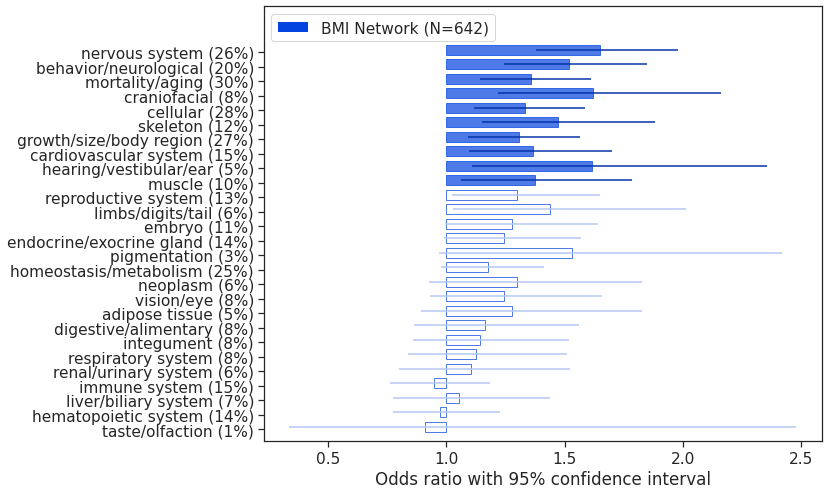

In [20]:
a = plot_hbar_comparison(results, communities=["C877"], mps=top_level, vert=8,
                         sig_level=0.05, community_names=["BMI Network"], sort_by_q=True, label_number="percent_community")


PARENT: MP:0000001 mammalian phenotype


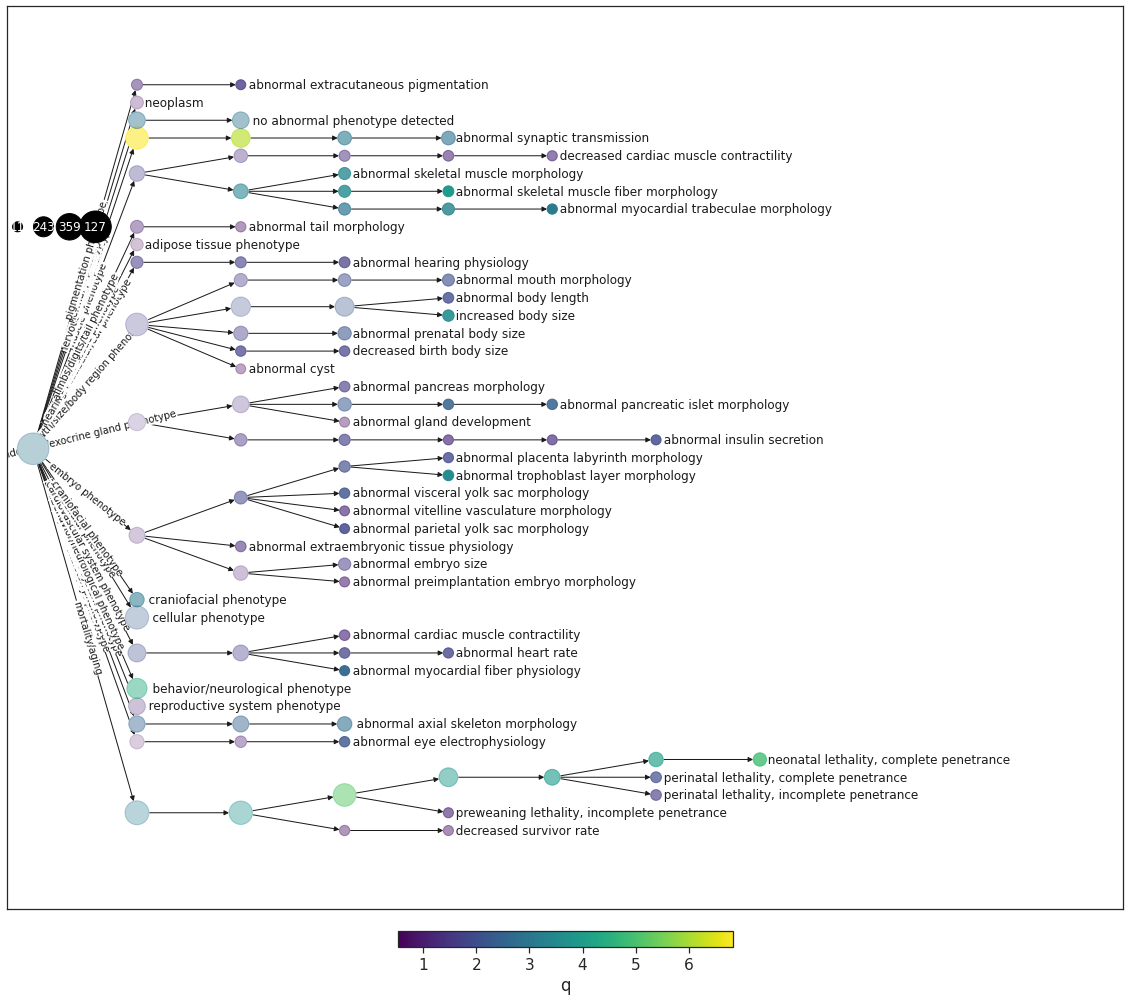

In [27]:
n = draw_significance_hierarchy(results.loc[results.observed > 10], "C877", "MP:0000001", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=20, label="leaf", descriptive_labels=True)

## Community selection

In [91]:
new_annotations = pd.read_csv("~/Data/Transfer/rat/update_GO_annotations.csv", usecols=["name", "represents"])
body_size_traits = ["MP:0005378", "MP:0003956", "MP:0010866", "MP:0005451"]
node_list = ["C917", "C889", "C887", "C885", "C888", "C900", "C886", "C882", "C905", "C881", "C920",
                "C880", "C934", "C931", "C912", "C883", "C878", "C891", "C884", "C879", "C907", "C909", "C894"]

### Heatmap with parent

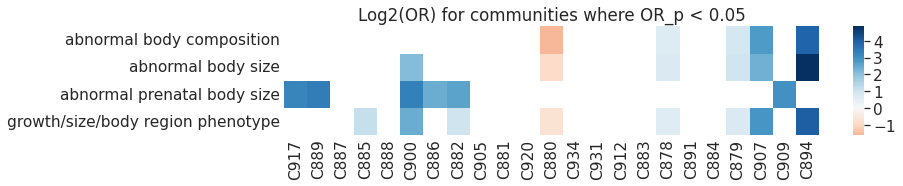

In [92]:
plot_community_heatmap(results, body_size_traits, node_list, new_annotations, stat="OR", filter_stat="OR_p")

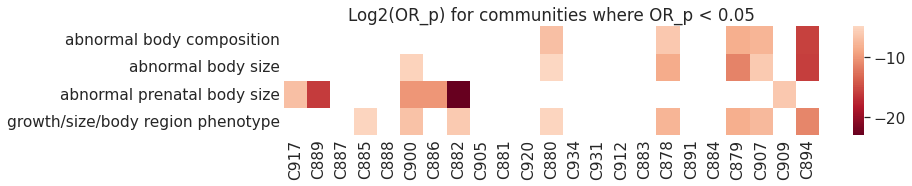

In [96]:
plot_community_heatmap(results, body_size_traits, node_list, new_annotations, stat="OR_p", filter_stat="OR_p")

### Heatmap without parent

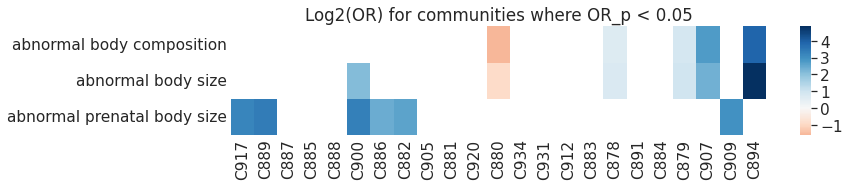

In [86]:
plot_community_heatmap(results, body_size_traits[1:], node_list, new_annotations, stat="OR", filter_stat="OR_p")

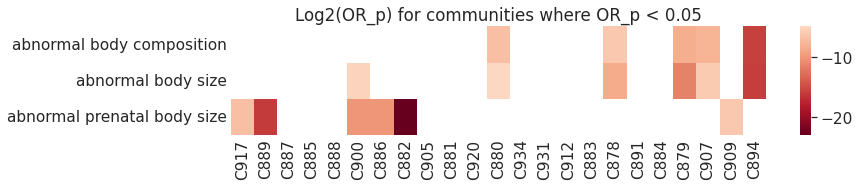

In [98]:
plot_community_heatmap(results, body_size_traits[1:], node_list, new_annotations, stat="OR_p", filter_stat="OR_p")

## GSR - C894

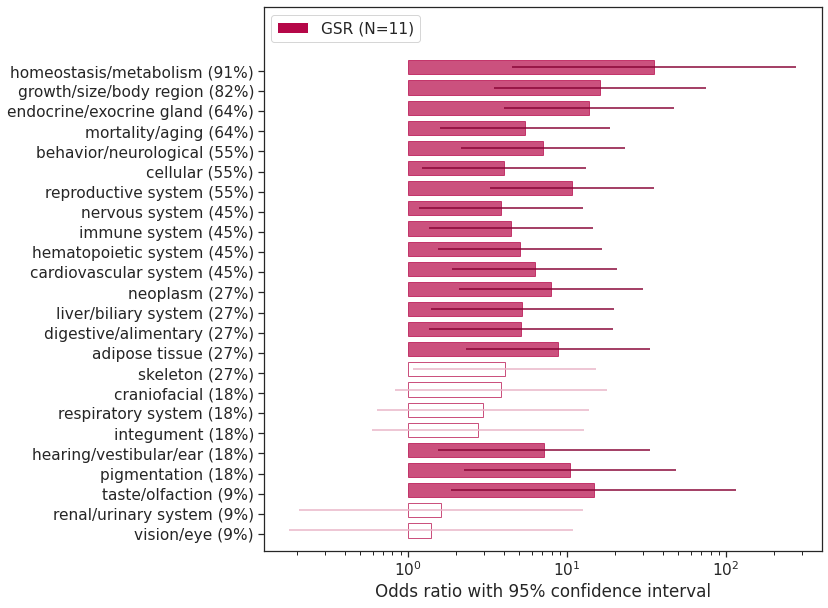

In [314]:
a = plot_hbar_comparison(results, communities=["C894"], mps=top_level, color_idx=3, vert = 10,
                         sig_level=0.05, community_names=["GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0000001 mammalian phenotype


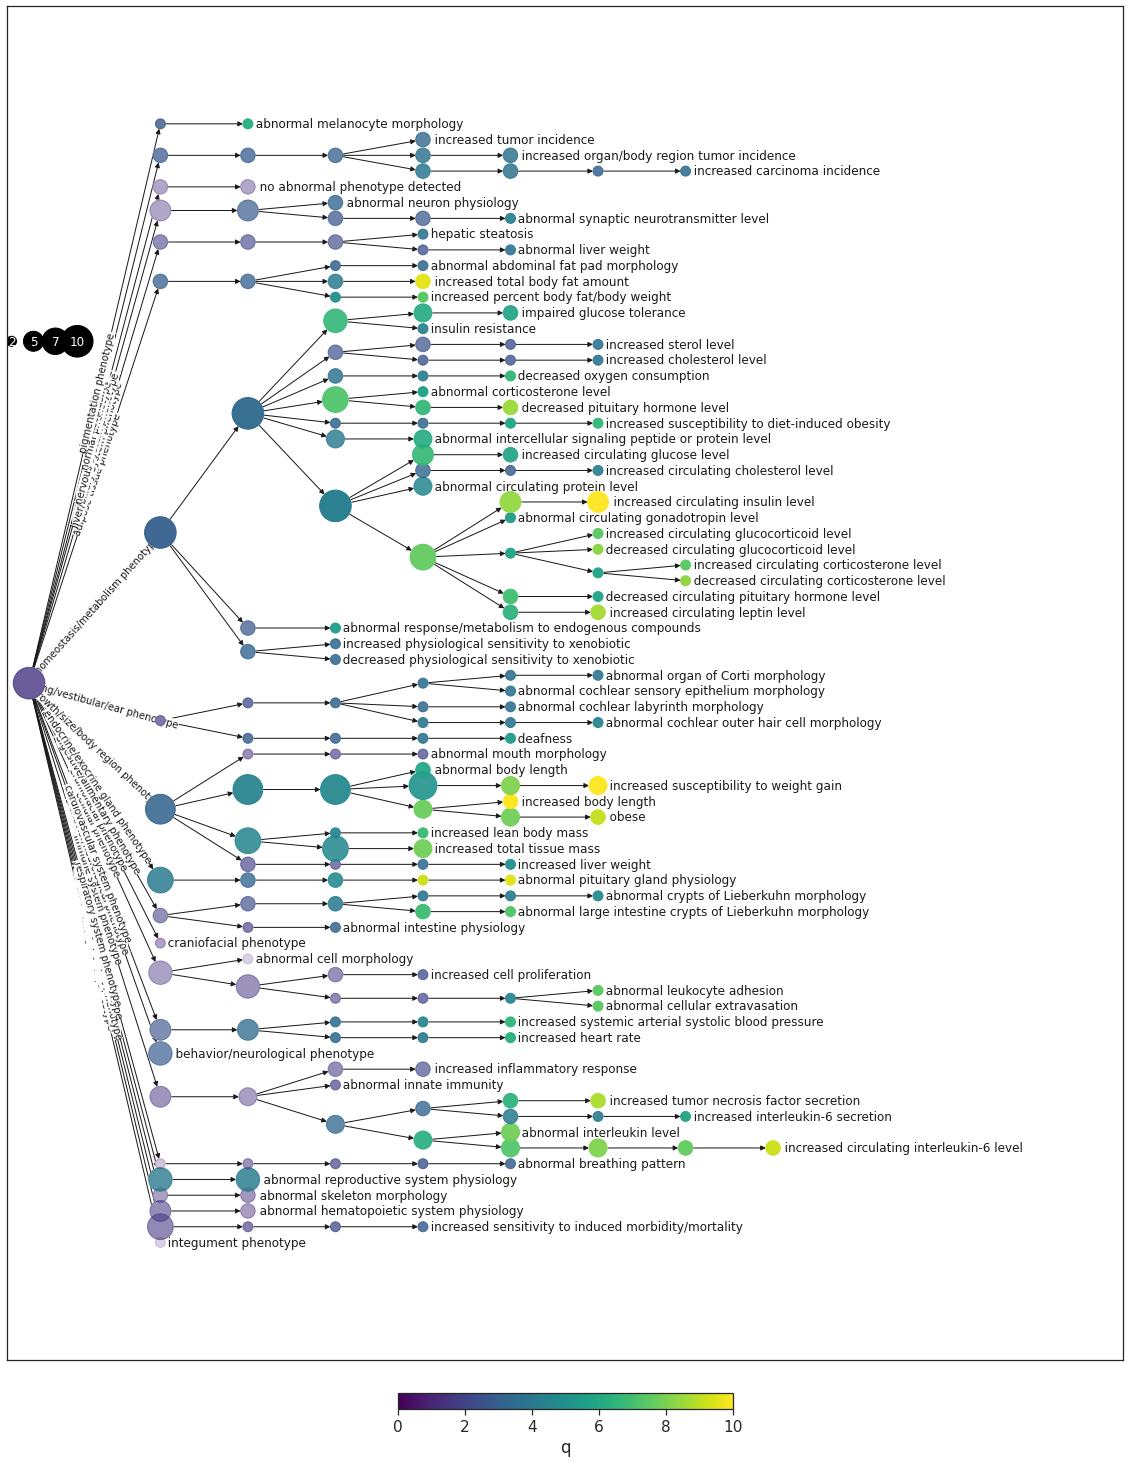

In [322]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0000001", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=30, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

### Homestasis/Metabolism

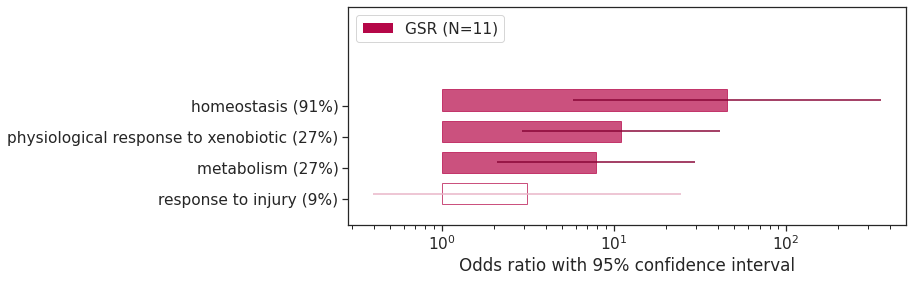

In [214]:
a = plot_hbar_comparison(results, communities=["C894"], mps="MP:0005376", color_idx=3, vert = 4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005376 homeostasis/metabolism phenotype


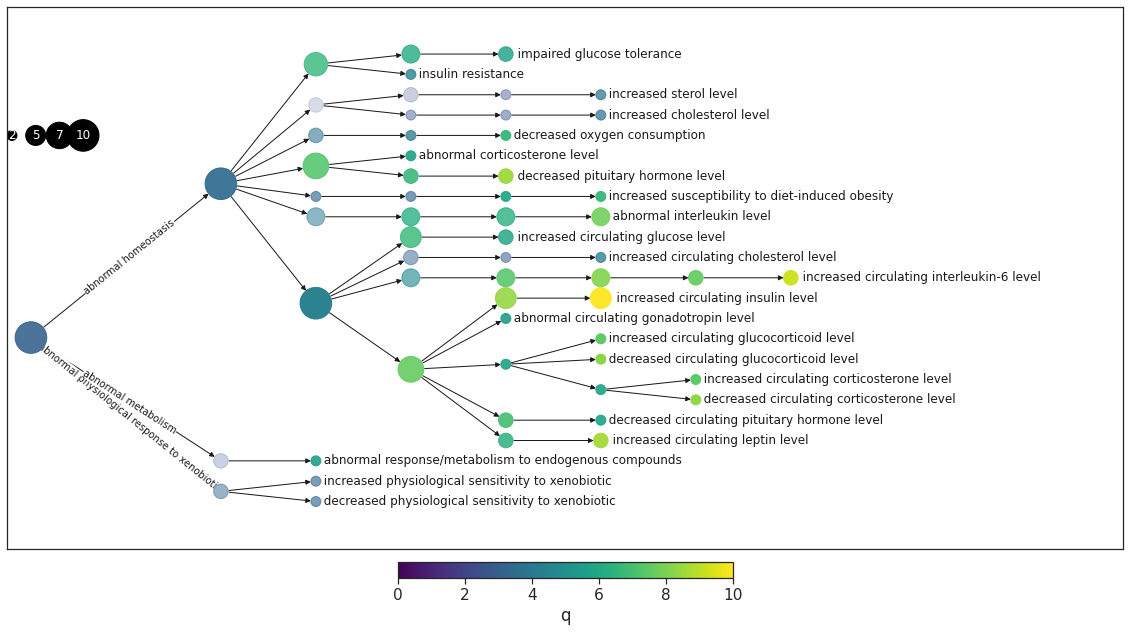

In [216]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005376", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=12, label="leaf", 
                                descriptive_labels=True, adjust_root=0.2)

### Growth/body size

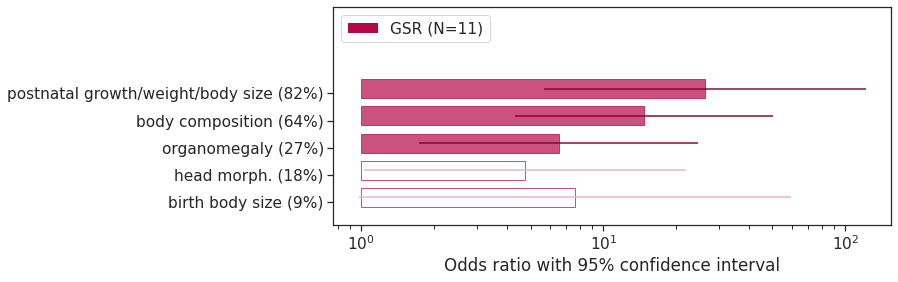

In [217]:
a = plot_hbar_comparison(results, communities=["C894"], mps="MP:0005378", color_idx=3, vert = 4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005378 growth/size/body region phenotype


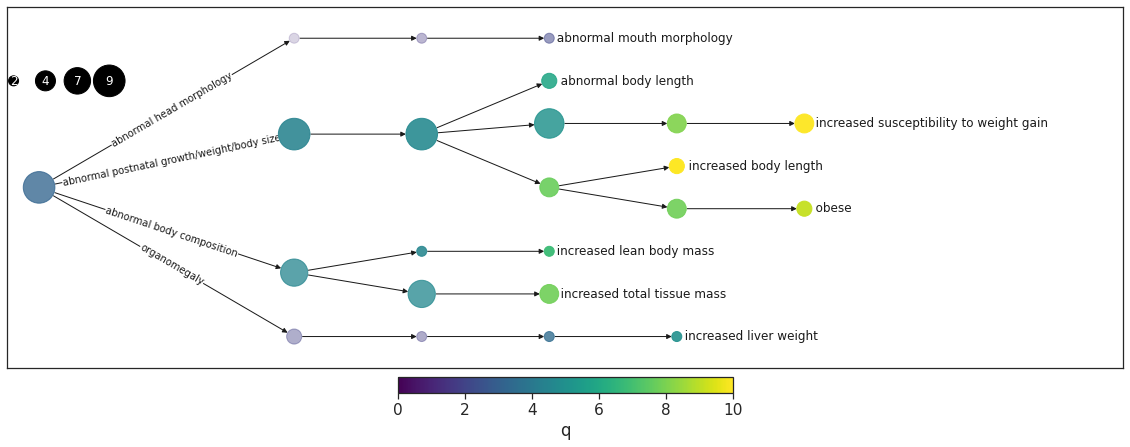

In [218]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005378", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=8, label="leaf", 
                                descriptive_labels=True, adjust_root=0.2)

### Endo/exocrine gland

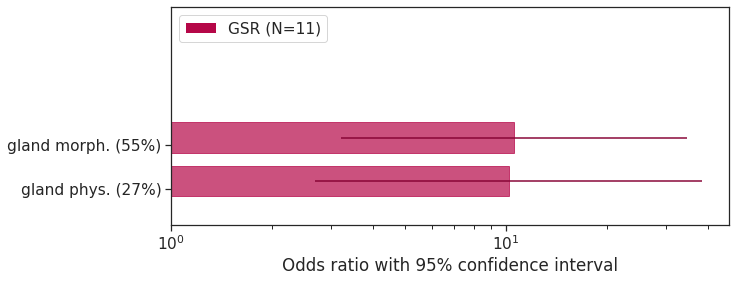

In [219]:
a = plot_hbar_comparison(results, communities=["C894"], mps="MP:0005379", color_idx=3, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005379 endocrine/exocrine gland phenotype


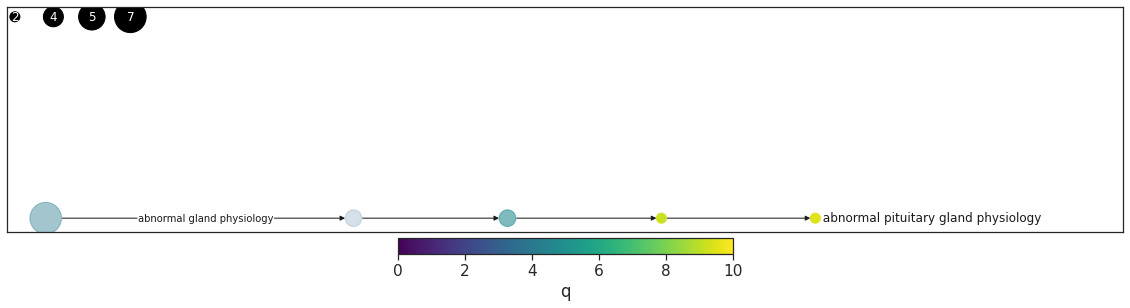

In [221]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005379", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0.2)

### Mortality/aging

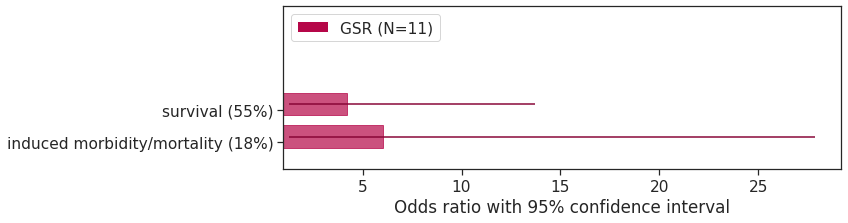

In [223]:
a = plot_hbar_comparison(results, communities=["C894"], mps="MP:0010768", color_idx=3, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0010768 mortality/aging


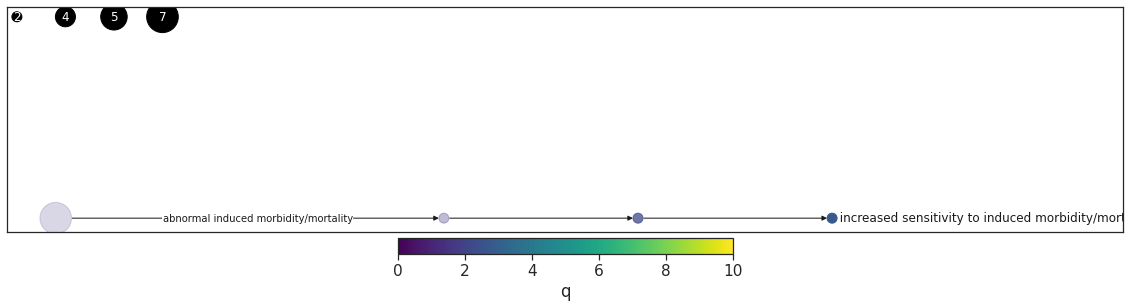

In [225]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0010768", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0.2)

### Behavior/neurological

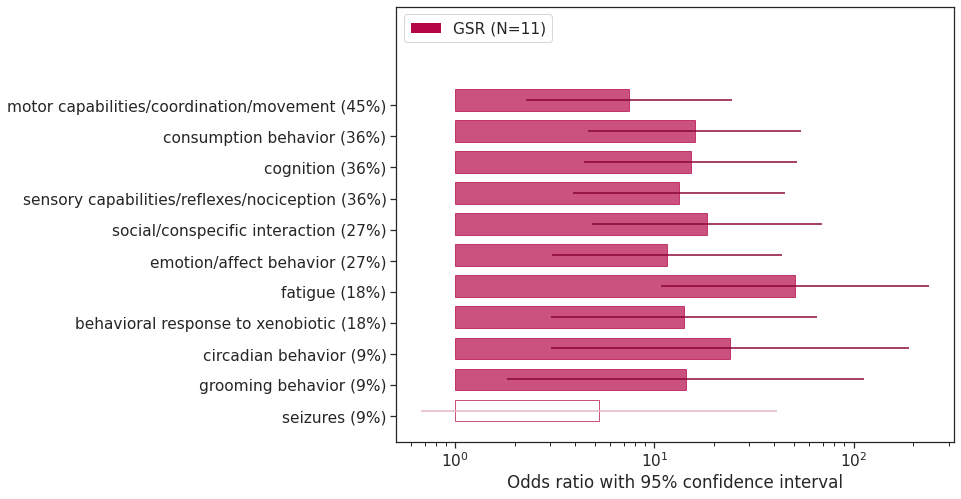

In [228]:
a = plot_hbar_comparison(results, communities=["C894"], mps="MP:0004924", color_idx=3, vert = 8, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0004924 abnormal behavior


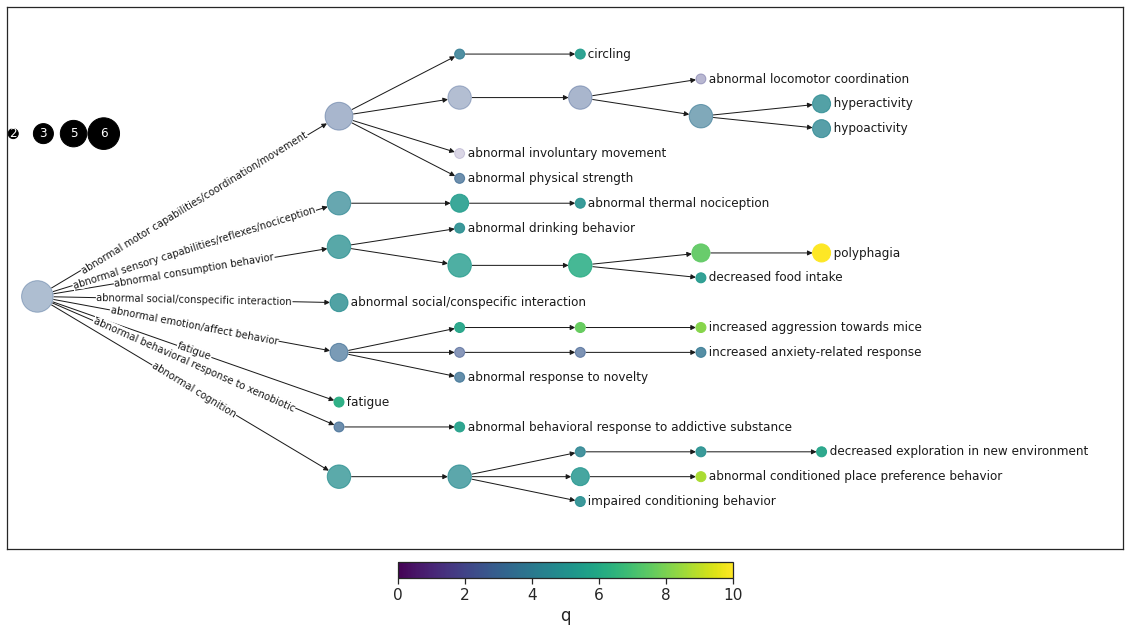

In [229]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0004924", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=12, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### Cellular

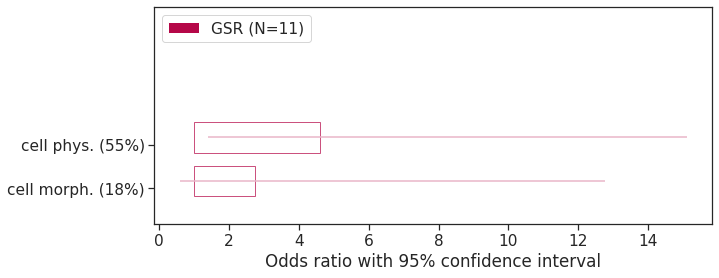

In [230]:
a = plot_hbar_comparison(results, communities=["C894"], mps="MP:0005384", color_idx=3, vert = 4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005384 cellular phenotype


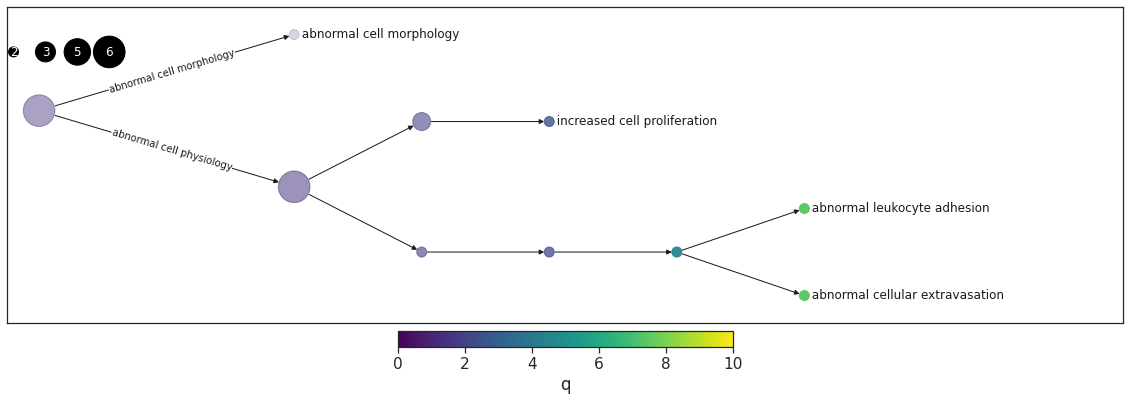

In [232]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005384", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.2)

### Reproductive

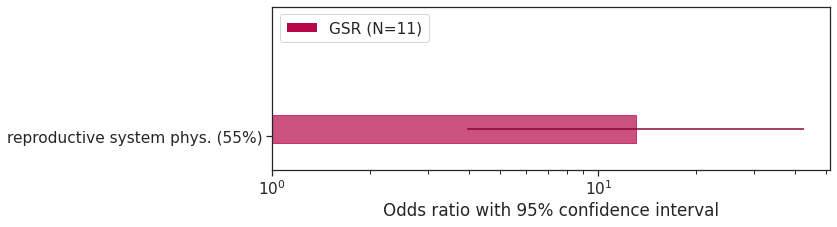

In [233]:
a = plot_hbar_comparison(results, communities=["C894"], mps="MP:0005389", color_idx=3, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005389 reproductive system phenotype


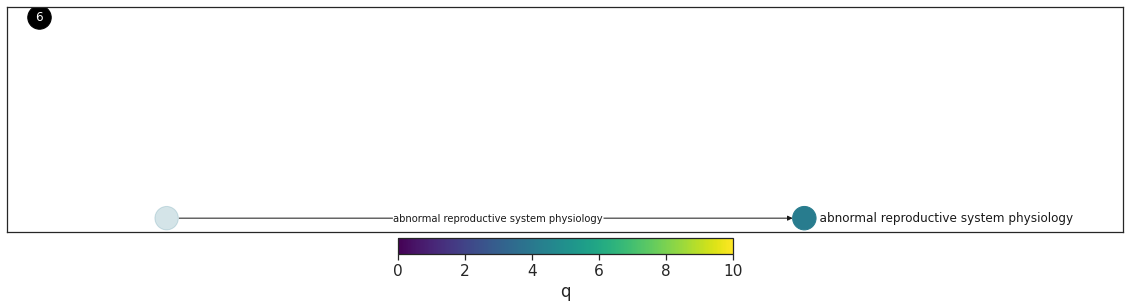

In [260]:
x = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005389", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0)

### Nervous system

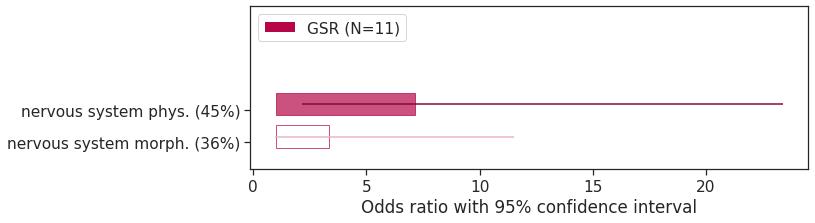

In [265]:
a = plot_hbar_comparison(results, communities=["C894"], mps="MP:0003631", color_idx=3, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0003631 nervous system phenotype


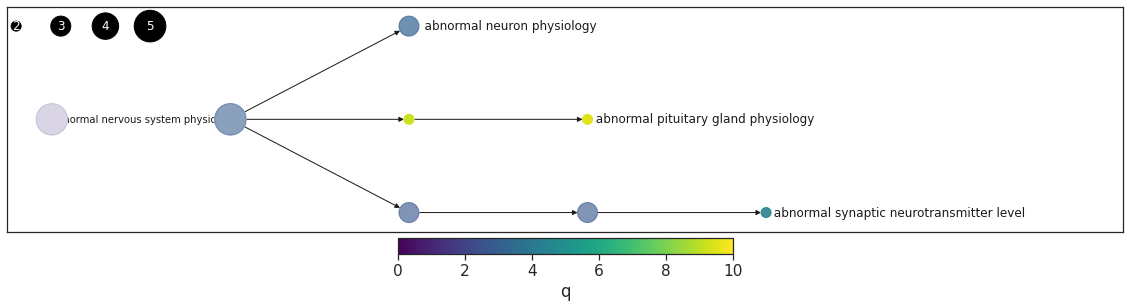

In [269]:
x = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0003631", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0)

### Immune system


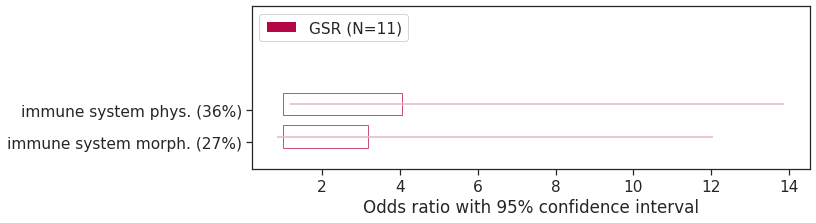

In [270]:
a = plot_hbar_comparison(results, communities=["C894"], mps="MP:0005387", color_idx=3, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005387 immune system phenotype


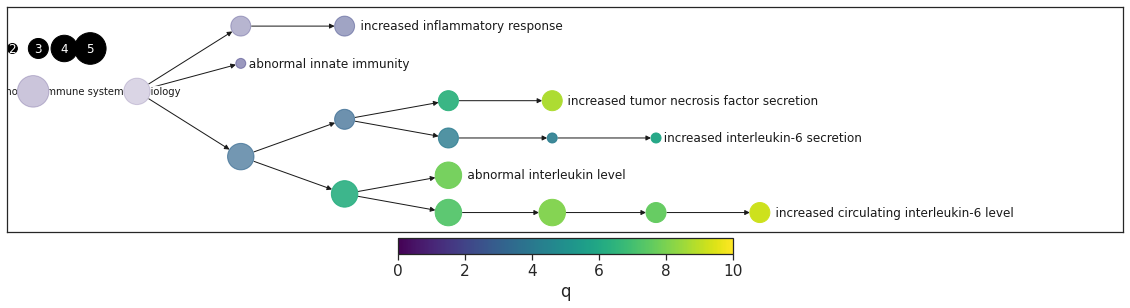

In [268]:
x = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005387", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0)

### Hematopoetic

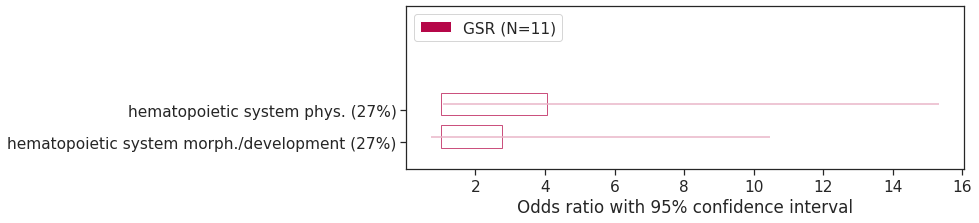

In [264]:
a = plot_hbar_comparison(results, communities=["C894"], mps="MP:0005397", color_idx=3, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005397 hematopoietic system phenotype


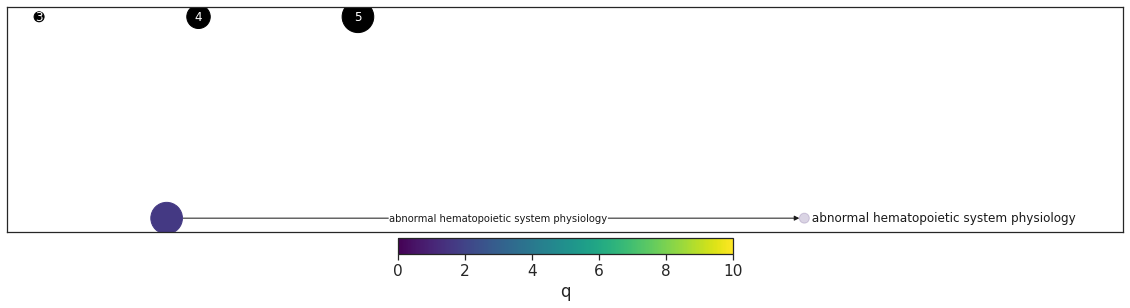

In [267]:
x = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005397", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0)

### Cardiovascular

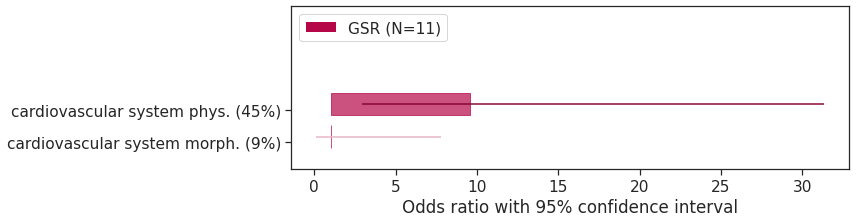

In [263]:
a = plot_hbar_comparison(results, communities=["C894"], mps="MP:0005385", color_idx=3, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["GSR"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005385 cardiovascular system phenotype


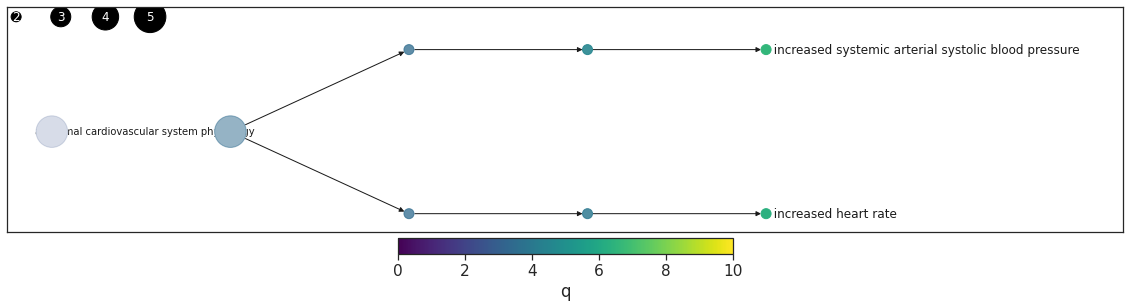

In [266]:
x = draw_significance_hierarchy(results.loc[results.observed>=2], "C894", "MP:0005385", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", 
                                descriptive_labels=True, adjust_root=0)

## DM1/DM2/DM3 - C882/C886/C900

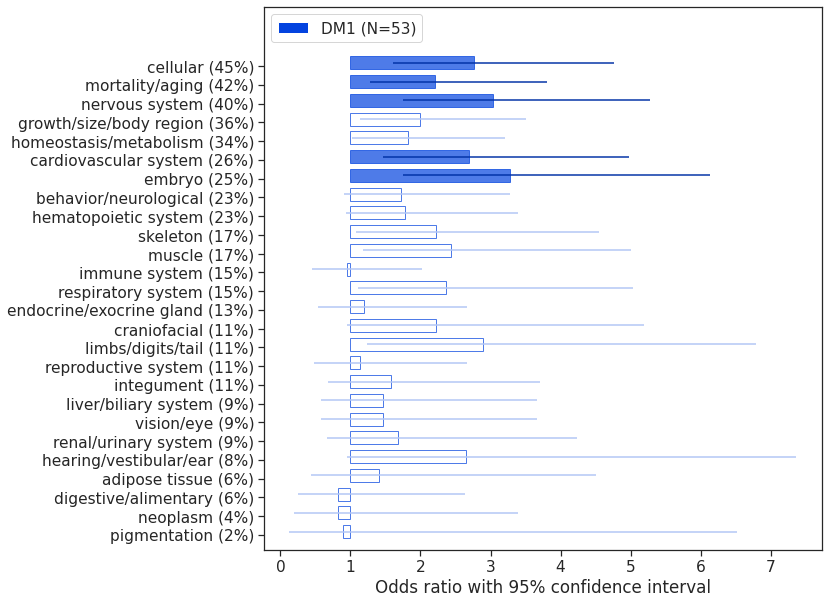

In [176]:
a = plot_hbar_comparison(results, communities=["C882"], mps=top_level, color_idx=1, vert = 10,
                         sig_level=0.05, community_names=["DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0000001 mammalian phenotype


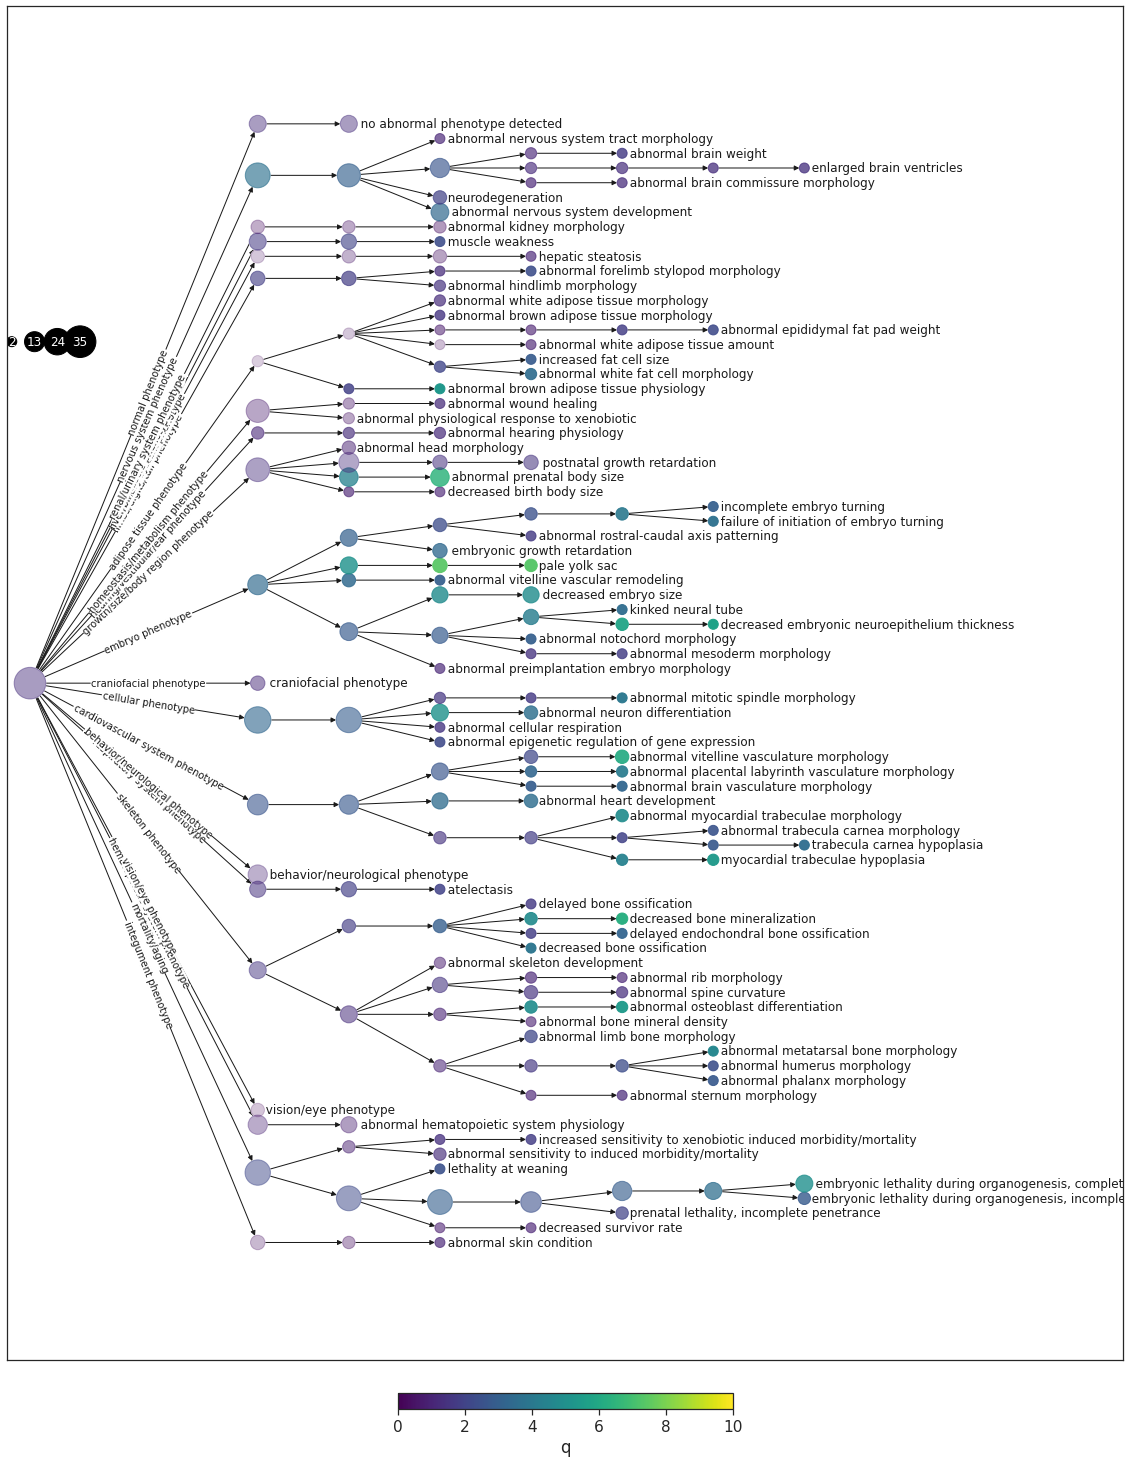

In [313]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0000001", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=30, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

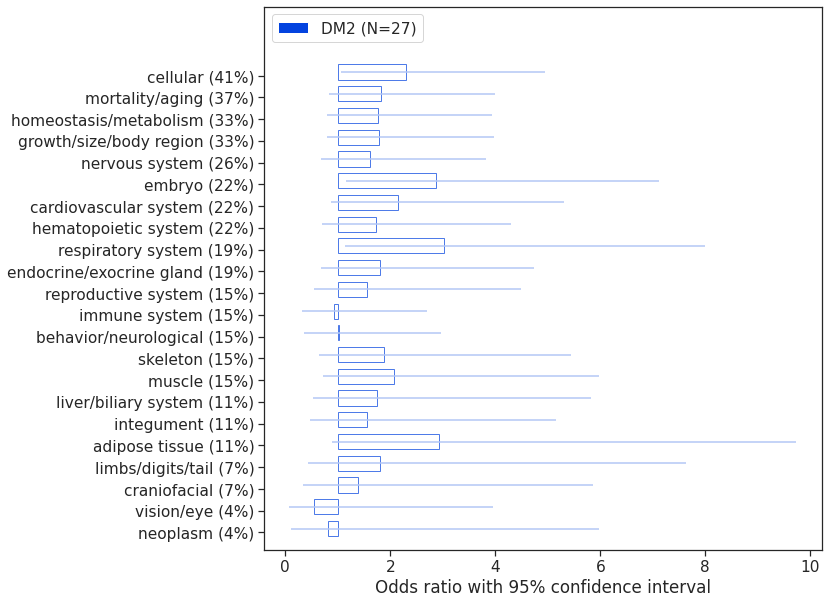

In [177]:
a = plot_hbar_comparison(results, communities=["C886"], mps=top_level, color_idx=1, vert = 10,
                         sig_level=0.05, community_names=["DM2"], sort_by="observed", label_number="percent_community")

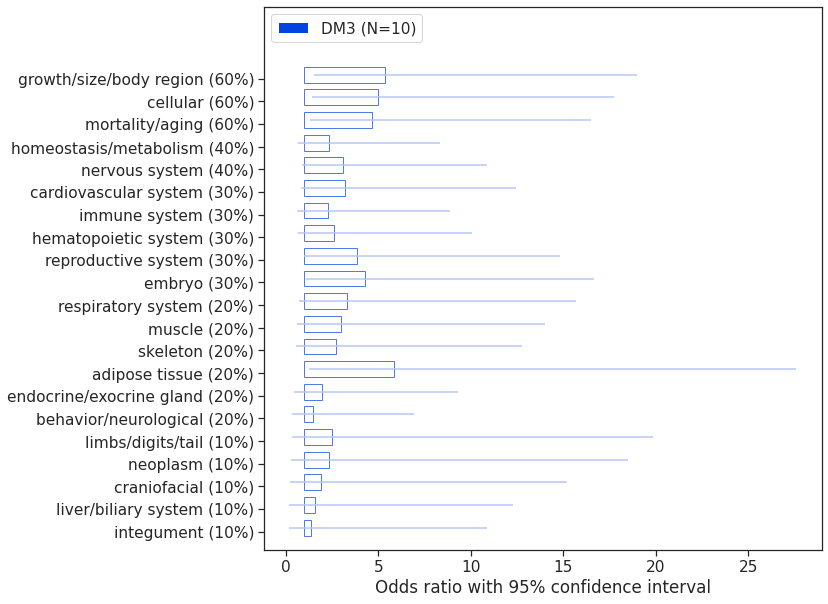

In [178]:
a = plot_hbar_comparison(results, communities=["C900"], mps=top_level, color_idx=1, vert = 10,
                         sig_level=0.05, community_names=["DM3"], sort_by="observed", label_number="percent_community")

### Cellular

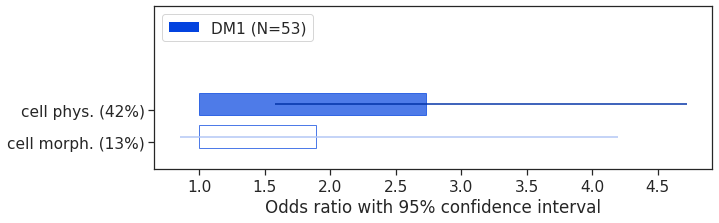

In [203]:
a = plot_hbar_comparison(results[results.observed>=2], communities=["C882"], mps="MP:0005384", color_idx=1, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005384 cellular phenotype


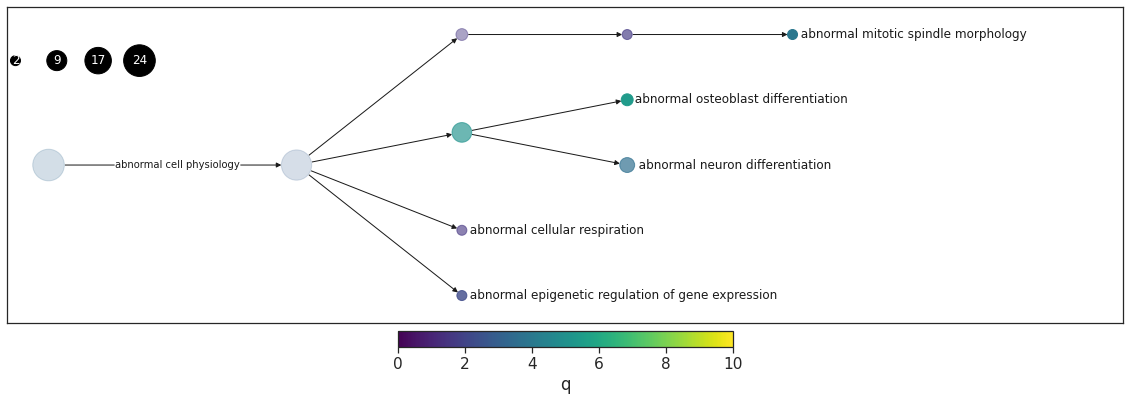

In [202]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0005384", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

### Mortality/aging

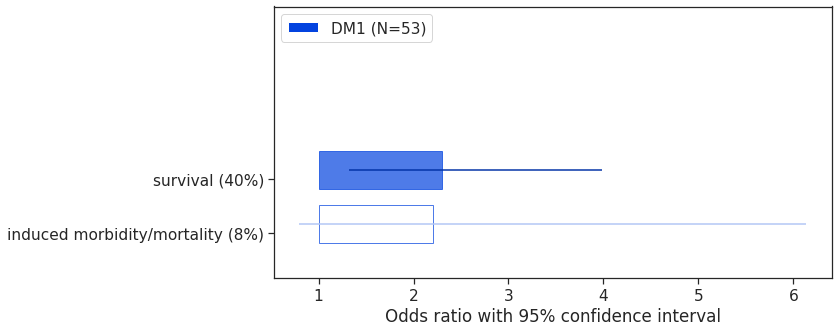

In [185]:
a = plot_hbar_comparison(results[results.observed>=2], communities=["C882"], mps="MP:0010768", color_idx=1, vert = 5,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0010768 mortality/aging


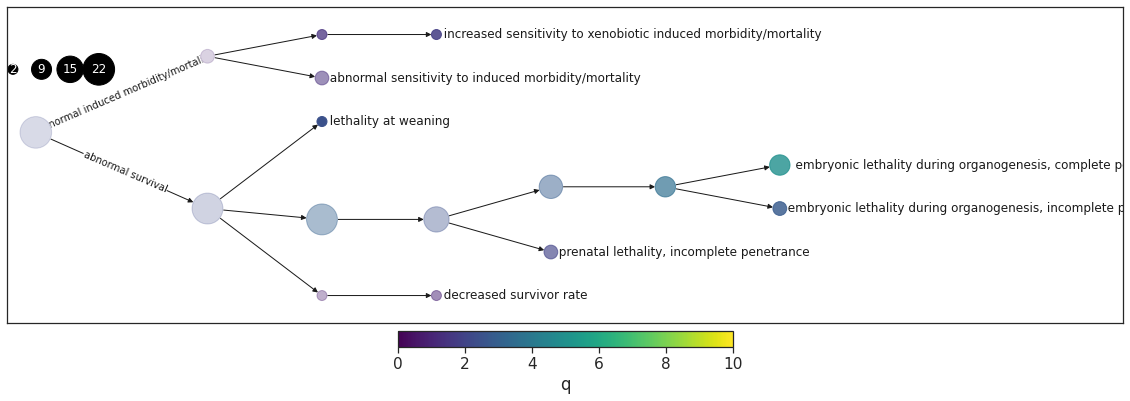

In [186]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0010768", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

### Nervous System

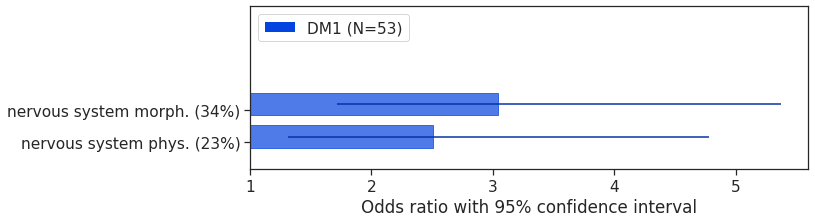

In [189]:
a = plot_hbar_comparison(results[results.observed>=2], communities=["C882"], mps="MP:0003631", color_idx=1, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0003631 nervous system phenotype


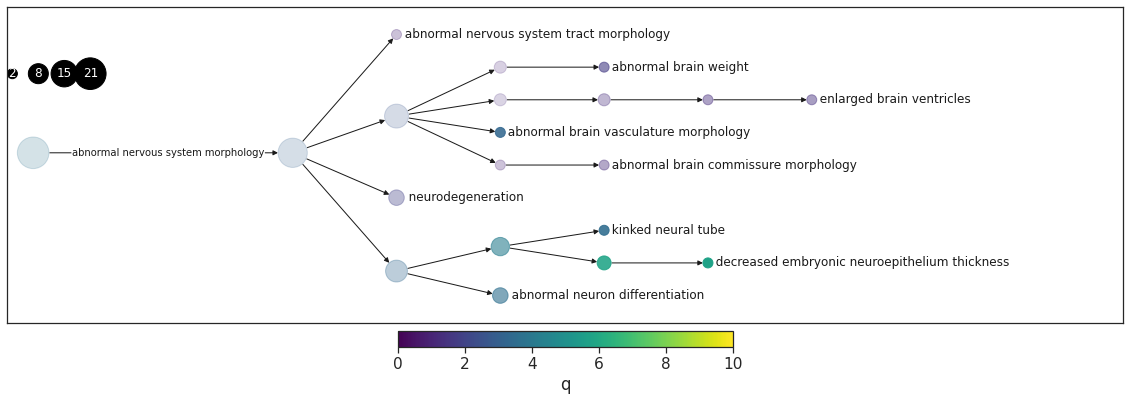

In [192]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0003631", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### Growth/body size

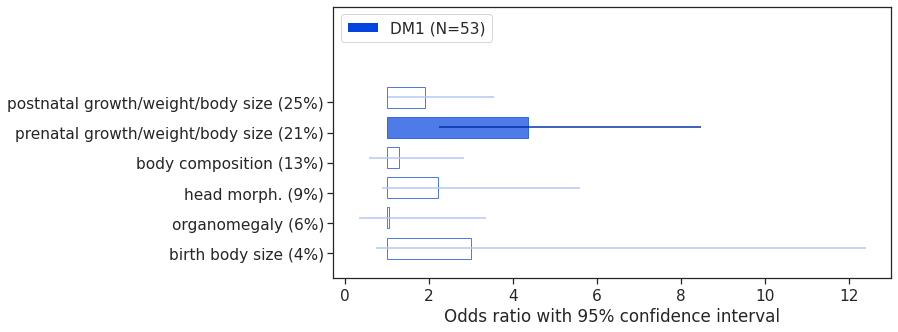

In [197]:
a = plot_hbar_comparison(results[results.observed>=2], communities=["C882"], mps="MP:0005378", color_idx=1, vert = 5,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005378 growth/size/body region phenotype


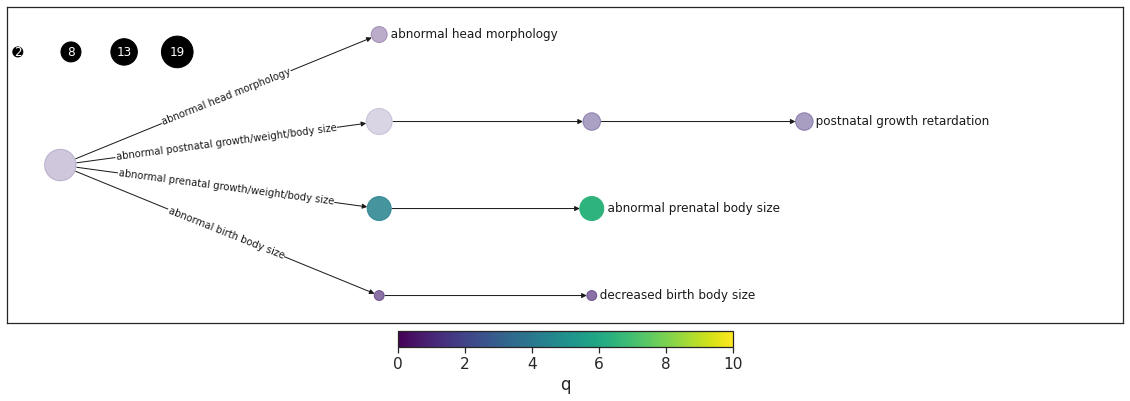

In [195]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0005378", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

### Homeostasis/metabolism

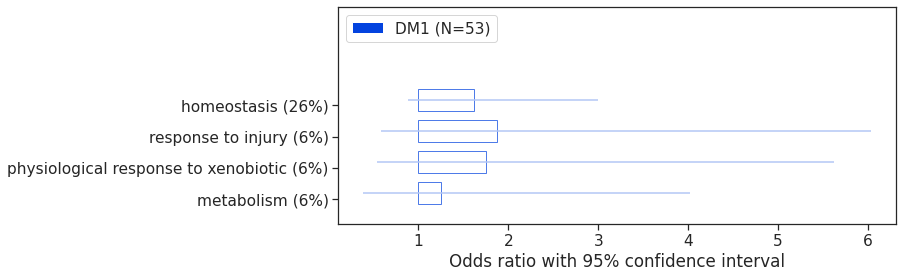

In [199]:
a = plot_hbar_comparison(results[results.observed>=2], communities=["C882"], mps="MP:0005376", color_idx=1, vert = 4,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005376 homeostasis/metabolism phenotype


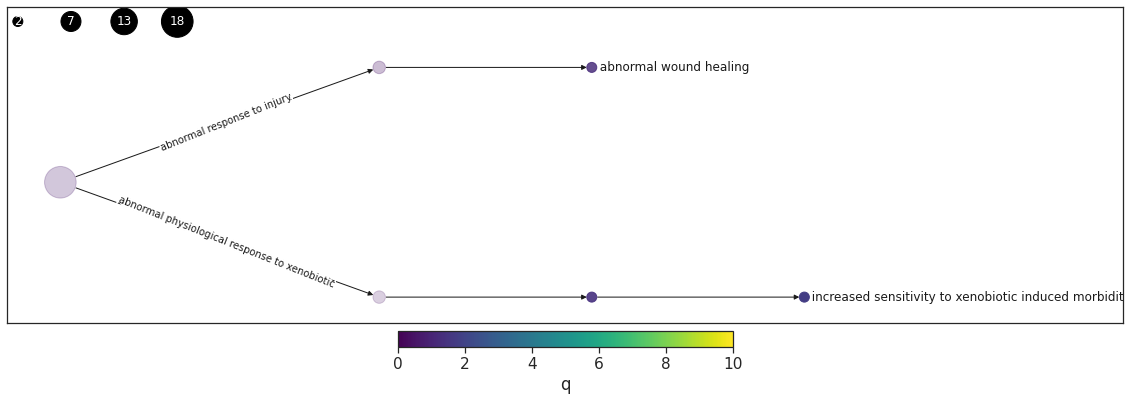

In [200]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0005376", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

### Cardiovascular

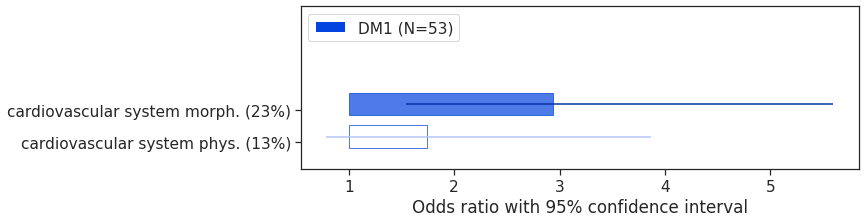

In [207]:
a = plot_hbar_comparison(results[results.observed>=2], communities=["C882"], mps="MP:0005385", color_idx=1, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005385 cardiovascular system phenotype


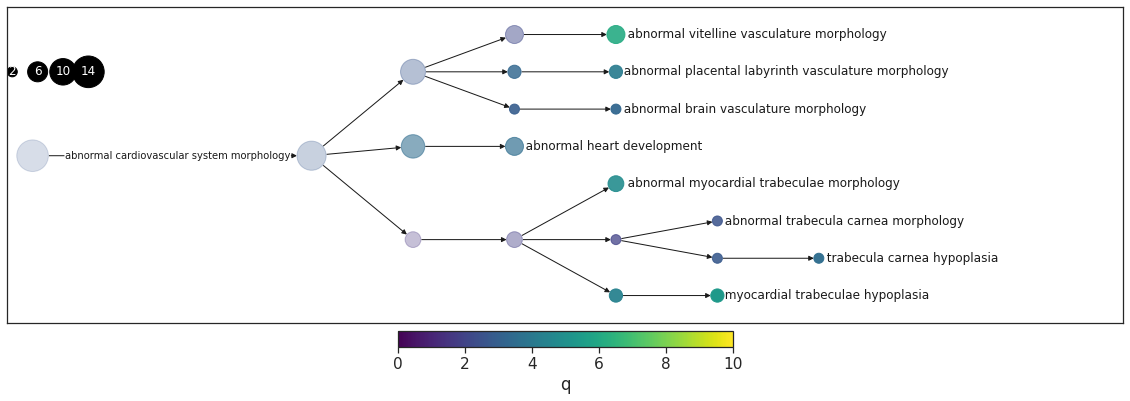

In [206]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0005385", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.35)

### Embryo

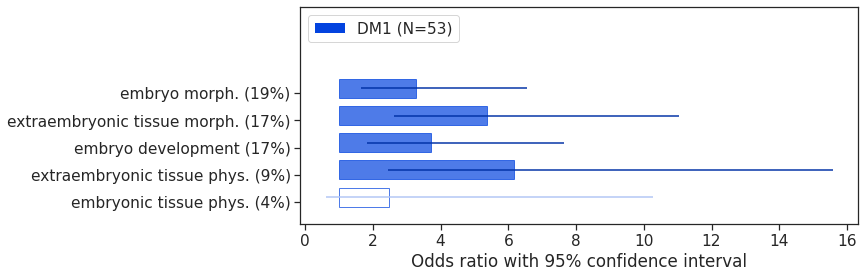

In [208]:
a = plot_hbar_comparison(results[results.observed>=2], communities=["C882"], mps="MP:0005380", color_idx=1, vert = 4,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005380 embryo phenotype


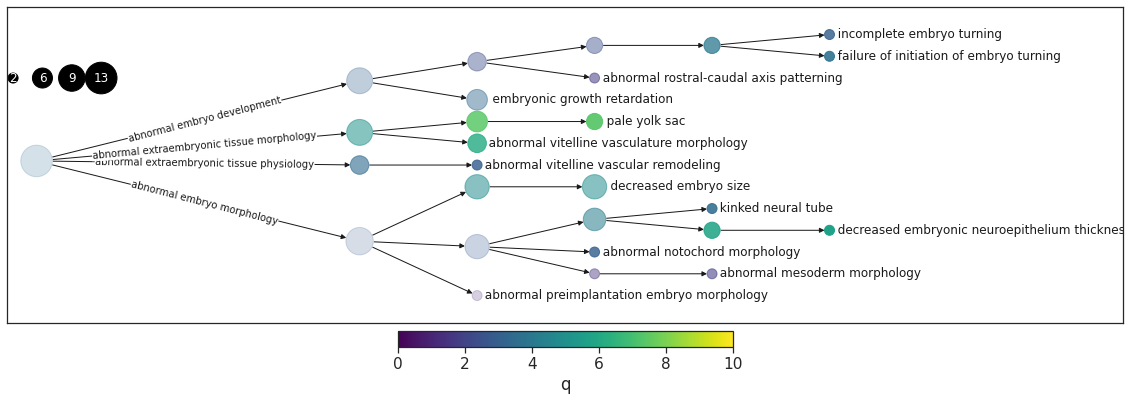

In [209]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C882", "MP:0005380", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.35)

## MSC - C907

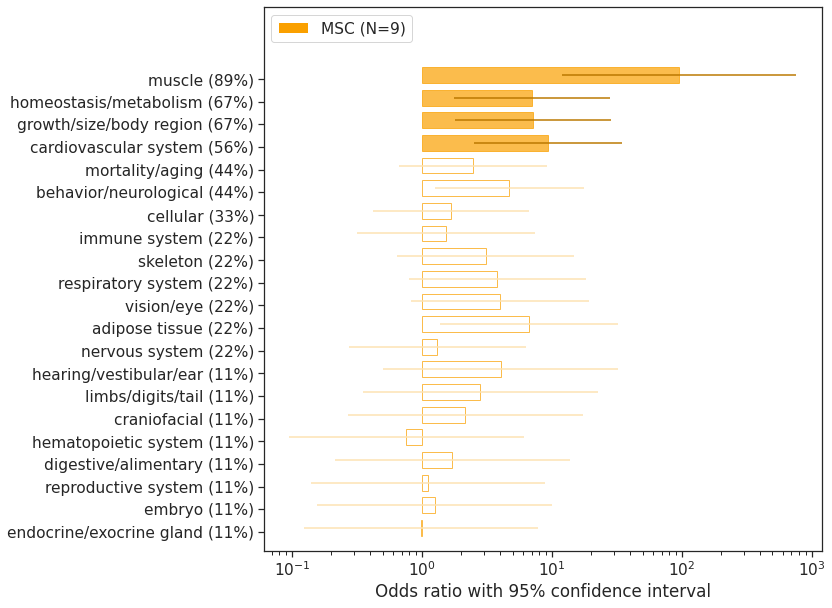

In [175]:
a = plot_hbar_comparison(results, communities=["C907"], mps=top_level, color_idx=2, vert = 10,
                         sig_level=0.05, community_names=["MSC"], sort_by="observed", label_number="percent_community")

PARENT: MP:0000001 mammalian phenotype


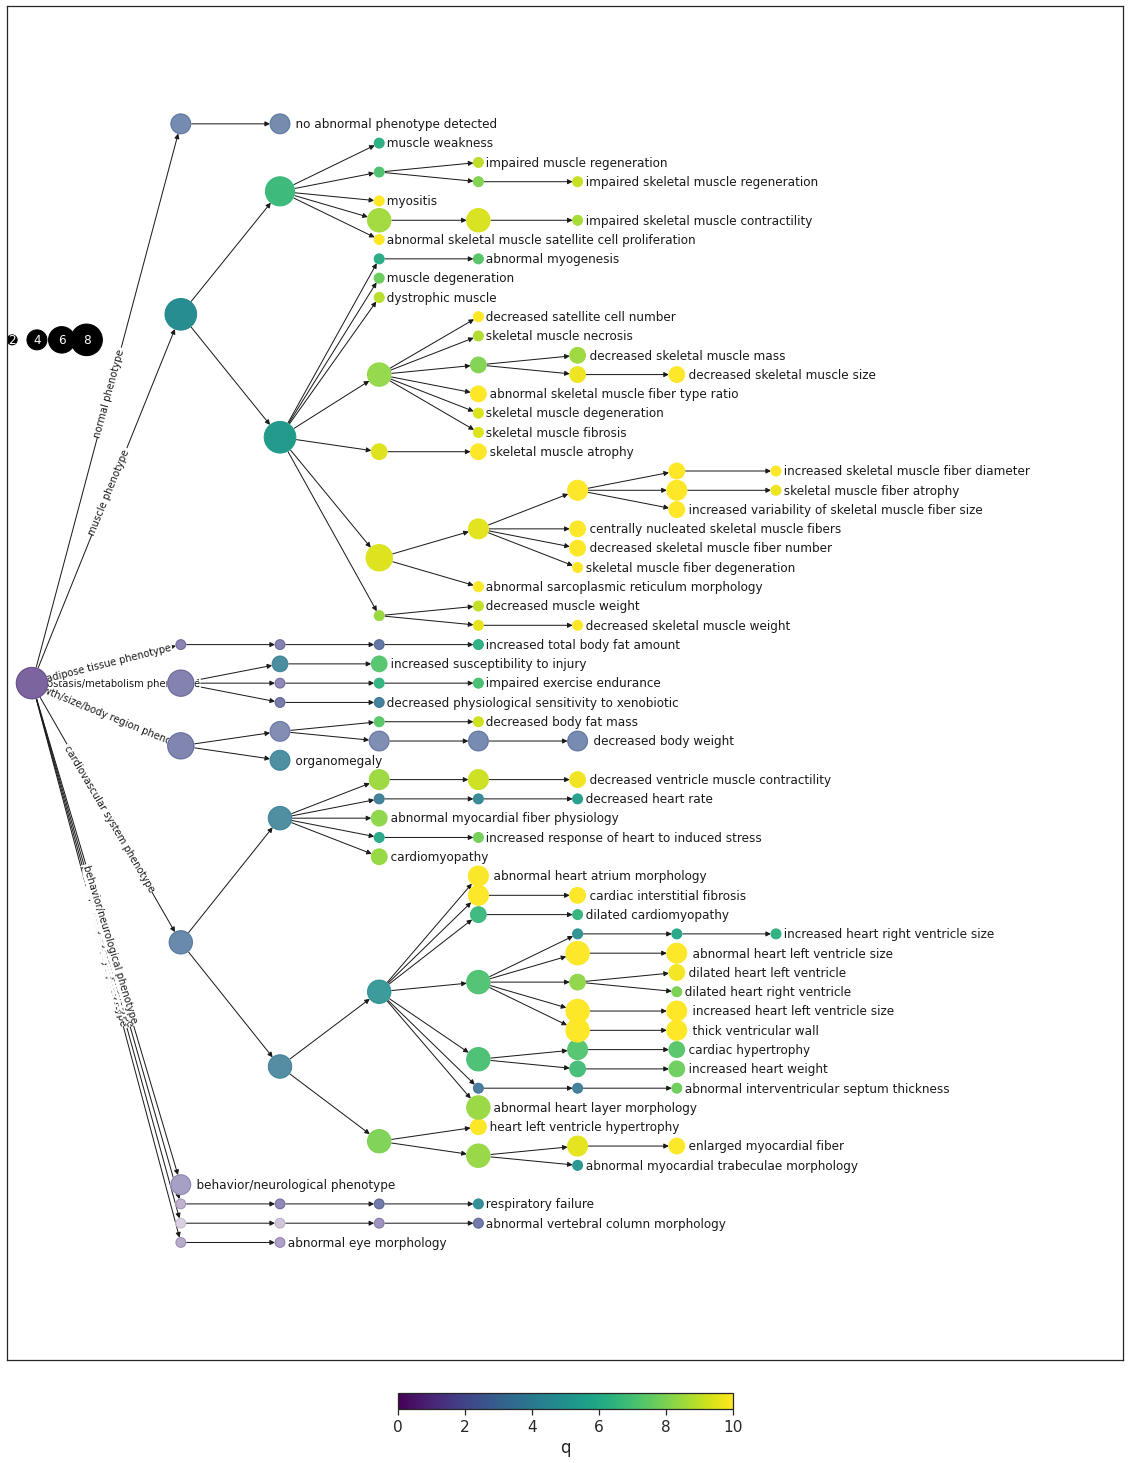

In [309]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C907", "MP:0000001", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=30, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

### Muscle

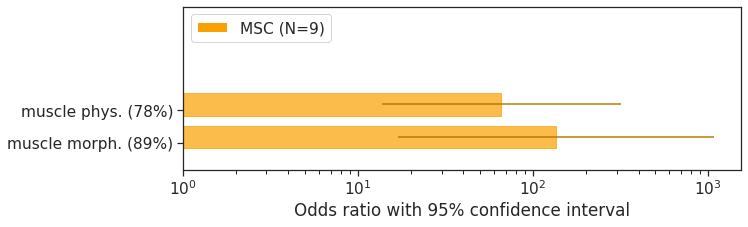

In [122]:
a = plot_hbar_comparison(results.loc[results.observed>=2], communities=["C907"], mps="MP:0005369", color_idx=2, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["MSC"], sort_by_q=True, label_number="percent_community")

PARENT: MP:0005369 muscle phenotype


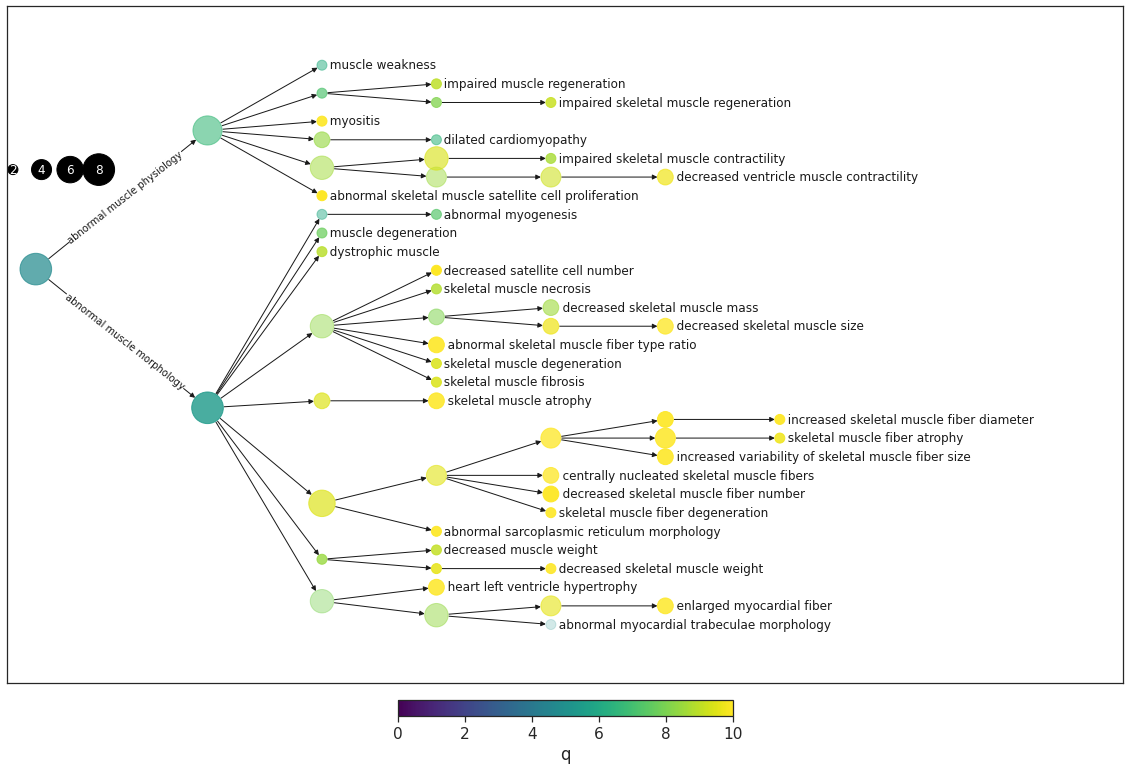

In [150]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C907", "MP:0005369", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=15, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

### Homeostatis/metabolism

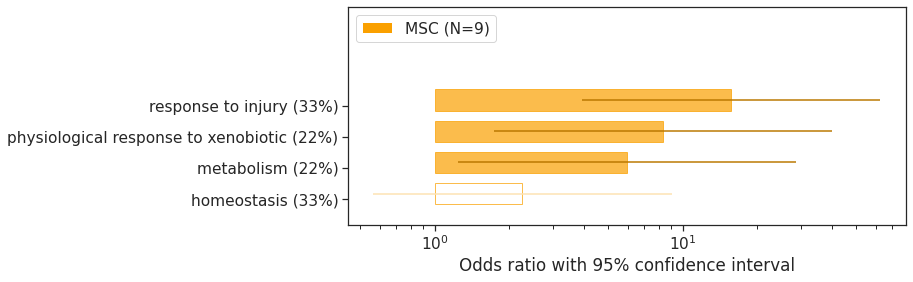

In [133]:
a = plot_hbar_comparison(results.loc[results.observed>=2], communities=["C907"], mps="MP:0005376", color_idx=2, vert=4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["MSC"], sort_by_q=True, label_number="percent_community")

PARENT: MP:0005376 homeostasis/metabolism phenotype


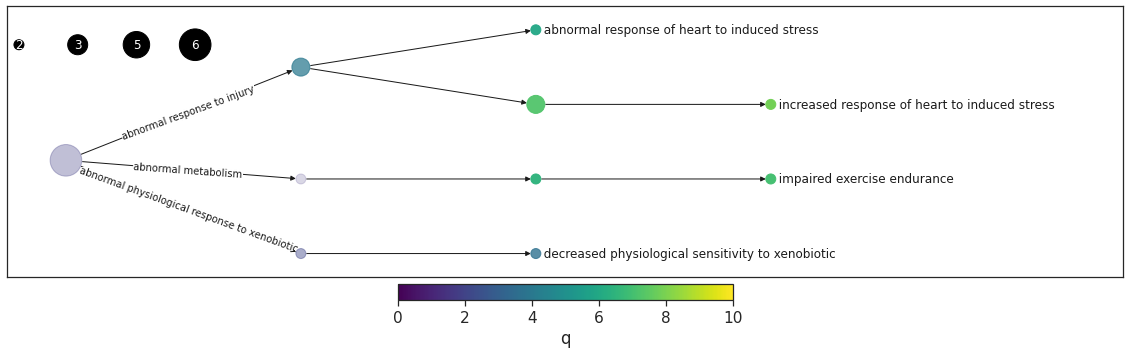

In [154]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C907", "MP:0005376", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=6, label="leaf", 
                                descriptive_labels=True)

### Growth/body size

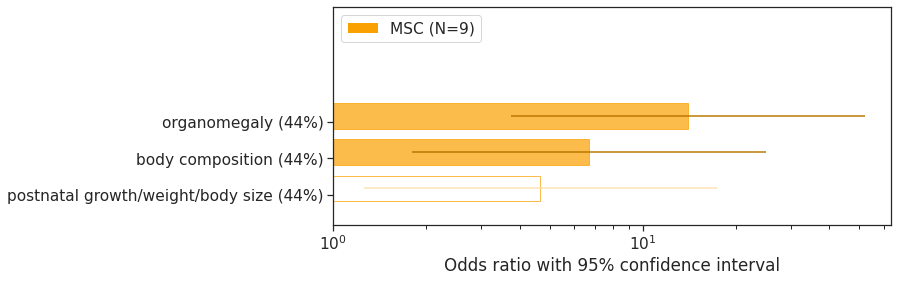

In [109]:
a = plot_hbar_comparison(results.loc[results.observed>=2], communities=["C907"], mps="MP:0005378", color_idx=2, vert=4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["MSC"], sort_by_q=True, label_number="percent_community")

PARENT: MP:0005378 growth/size/body region phenotype


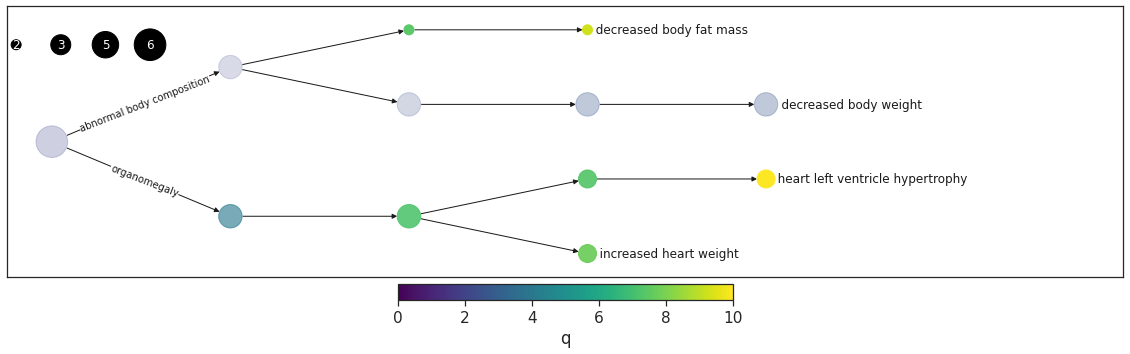

In [153]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C907", "MP:0005378", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=6, label="leaf", 
                                descriptive_labels=True)

### Cardiovascular

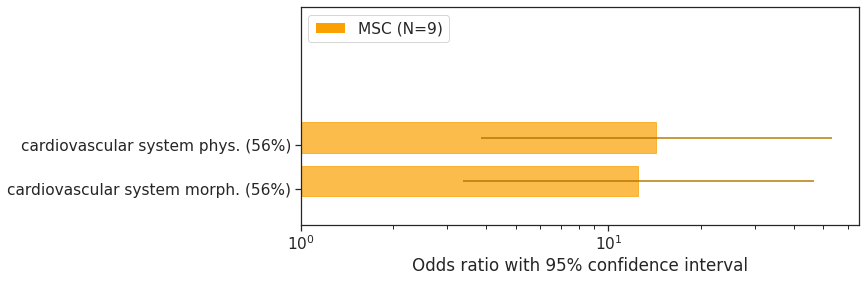

In [151]:
a = plot_hbar_comparison(results.loc[results.observed>=2], communities=["C907"], mps="MP:0005385", color_idx=2, vert=4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["MSC"], sort_by_q=True, label_number="percent_community")

PARENT: MP:0005385 cardiovascular system phenotype


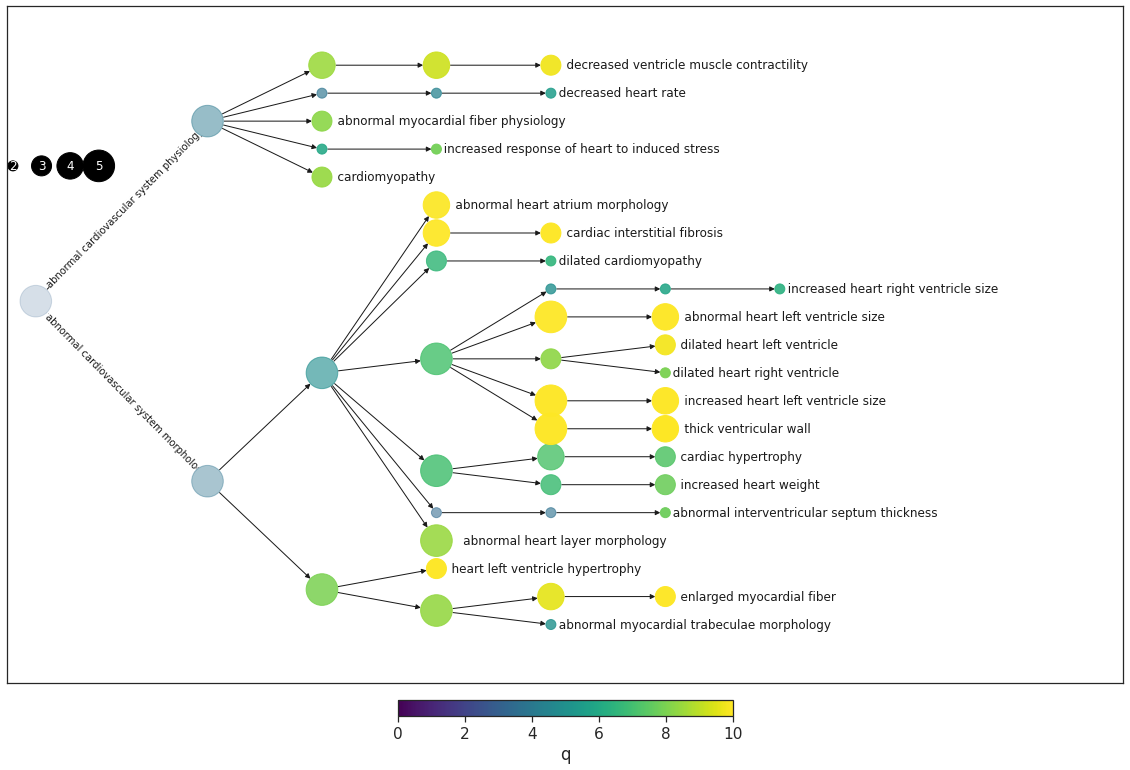

In [152]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C907", "MP:0005385", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=15, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

## PP/MPK2 - C889/C917

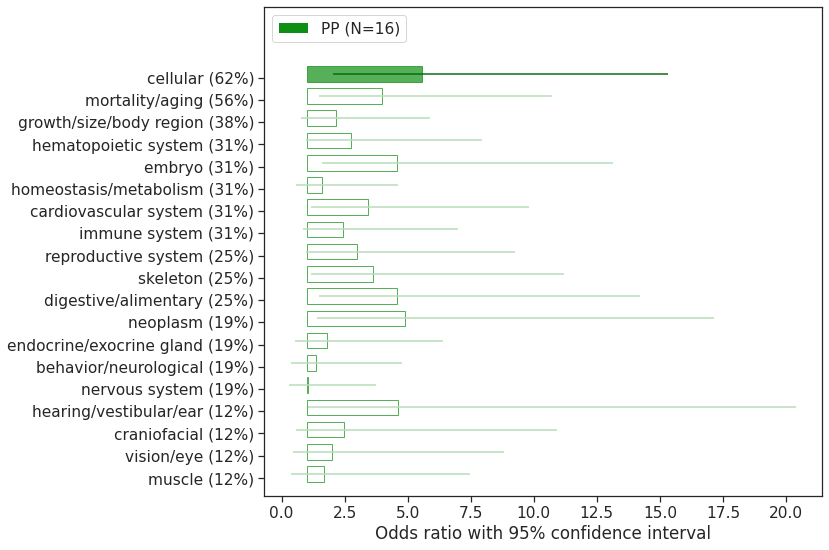

In [275]:
a = plot_hbar_comparison(results[results.observed>=2], communities=["C889"], mps=top_level, color_idx=0, vert = 9,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["PP"], sort_by="observed", label_number="percent_community")

PARENT: MP:0000001 mammalian phenotype


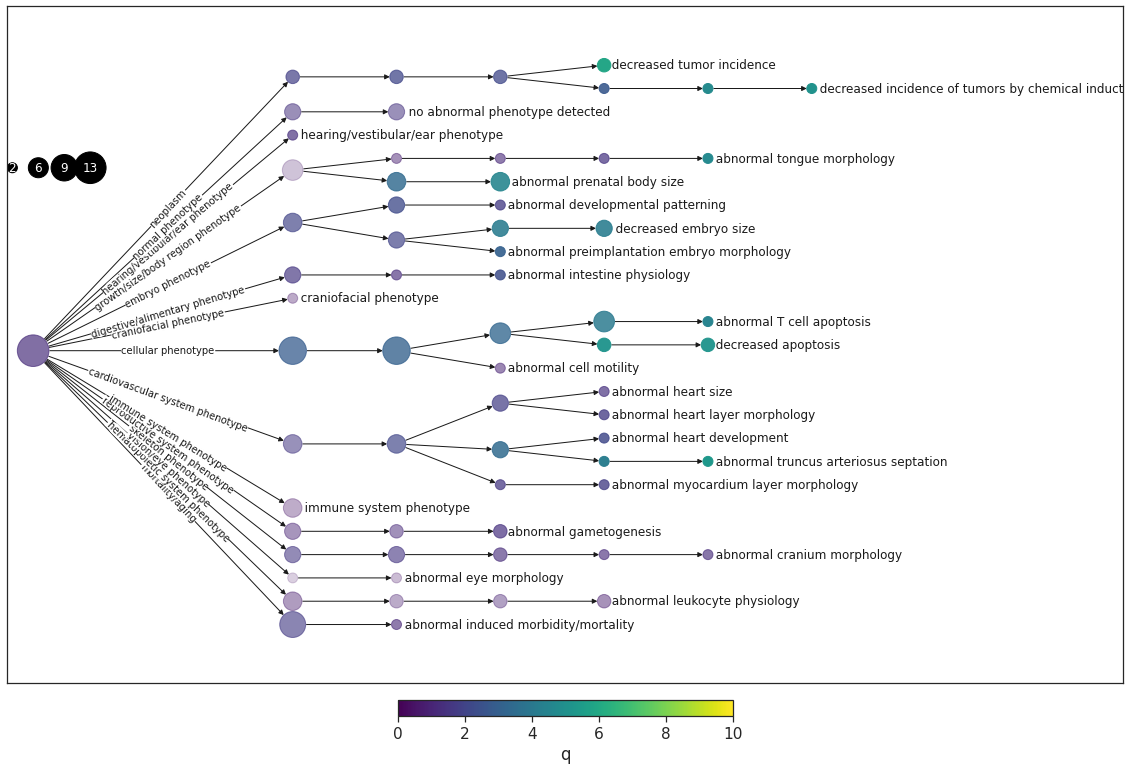

In [305]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C889", "MP:0000001", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=15, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### Cellular

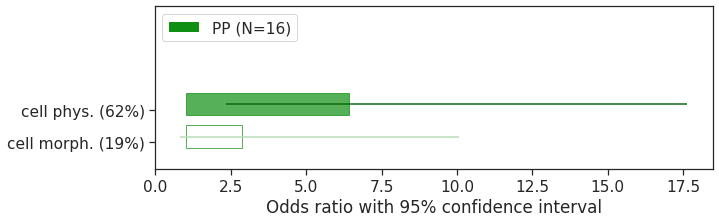

In [281]:
a = plot_hbar_comparison(results.loc[results.observed>=2], communities=["C889"], mps="MP:0005384", color_idx=0, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["PP"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005384 cellular phenotype


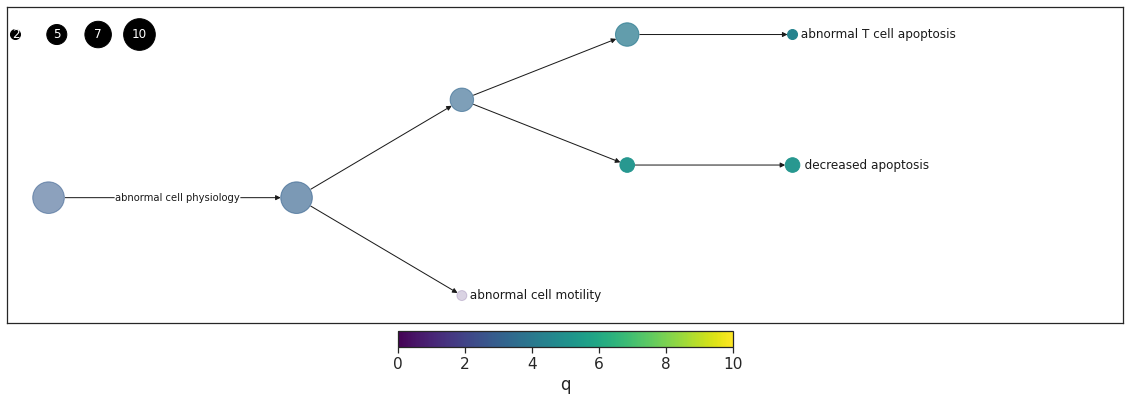

In [285]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C889", "MP:0005384", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

### Mortality/aging

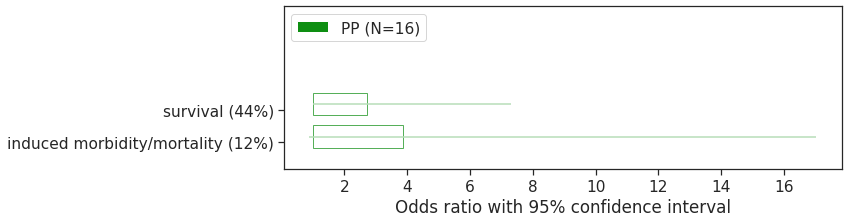

In [282]:
a = plot_hbar_comparison(results.loc[results.observed>=2], communities=["C889"], mps="MP:0010768", color_idx=0, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["PP"], sort_by="observed", label_number="percent_community")

PARENT: MP:0010768 mortality/aging


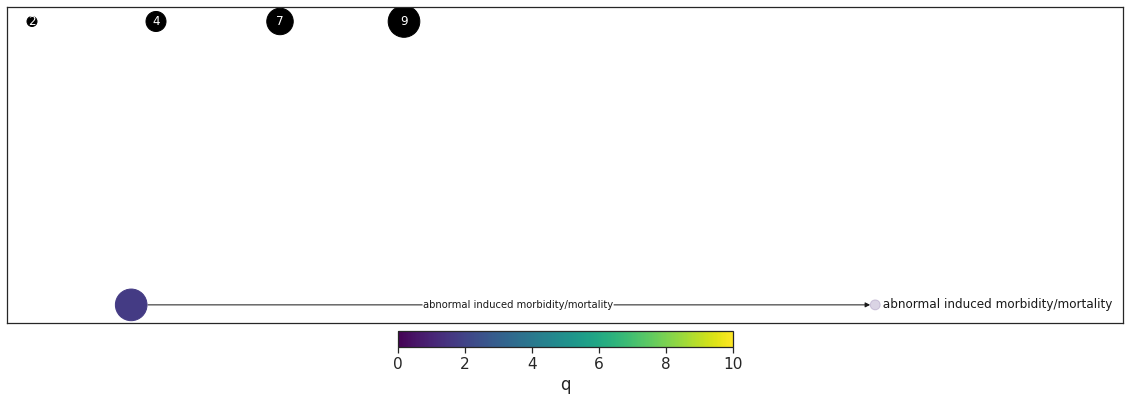

In [286]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C889", "MP:0010768", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

### Growth/body size

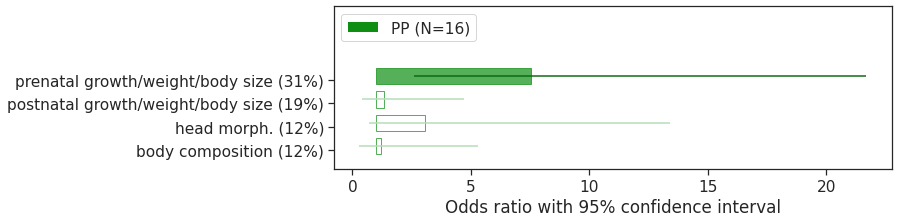

In [283]:
a = plot_hbar_comparison(results.loc[results.observed>=2], communities=["C889"], mps="MP:0005378", color_idx=0, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["PP"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005378 growth/size/body region phenotype


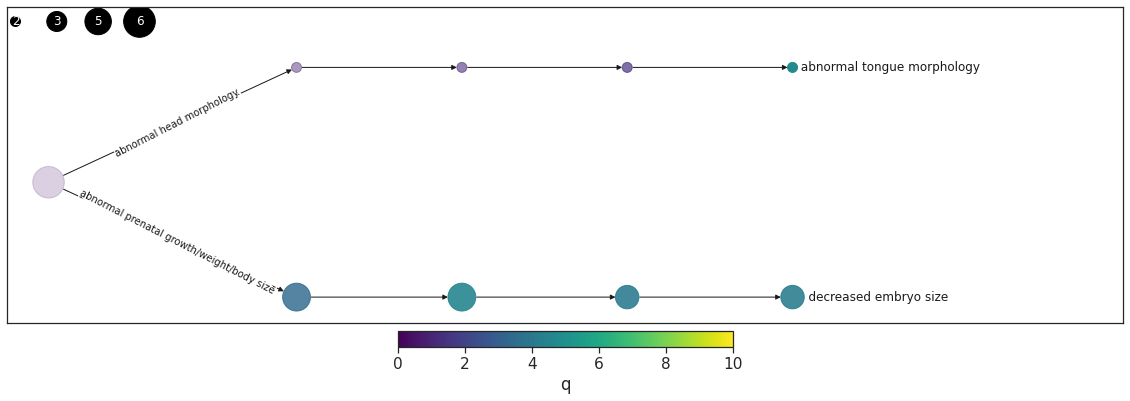

In [288]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C889", "MP:0005378", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

## C909

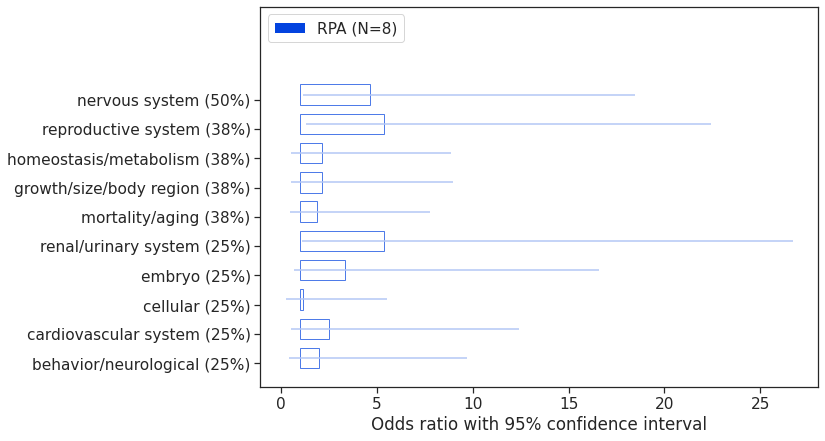

In [316]:
a = plot_hbar_comparison(results[results.observed>=2], communities=["C909"], mps=top_level, color_idx=1, vert = 7,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["RPA"], sort_by="observed", label_number="percent_community")

PARENT: MP:0000001 mammalian phenotype


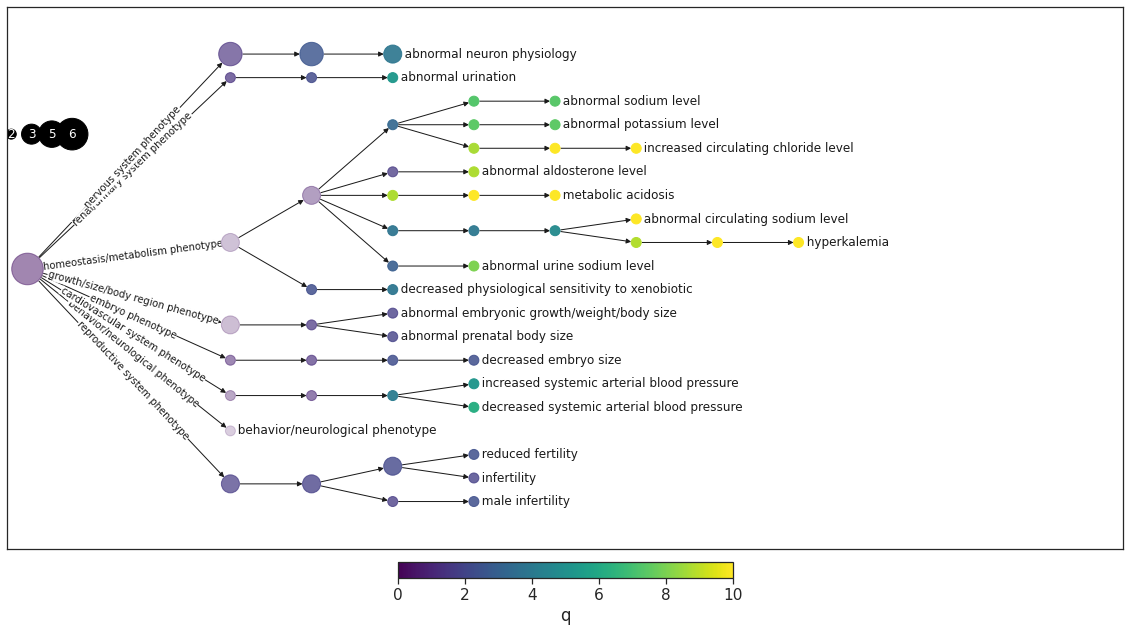

In [317]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C909", "MP:0000001", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=12, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### Nervous System

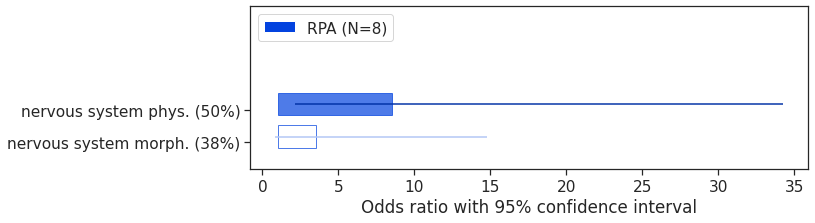

In [318]:
a = plot_hbar_comparison(results[results.observed>=2], communities=["C909"], mps="MP:0003631", color_idx=1, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["RPA"], sort_by="observed", label_number="percent_community")

PARENT: MP:0003631 nervous system phenotype


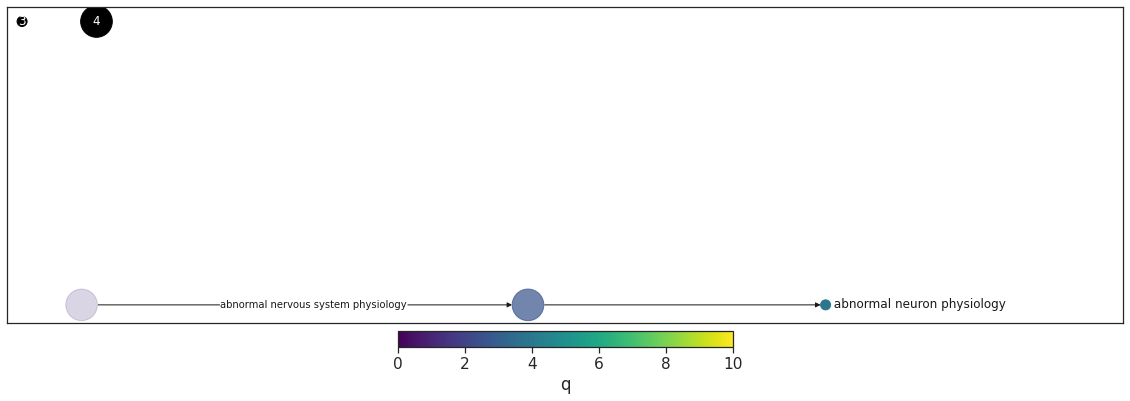

In [297]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C909", "MP:0003631", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

### Reproductive

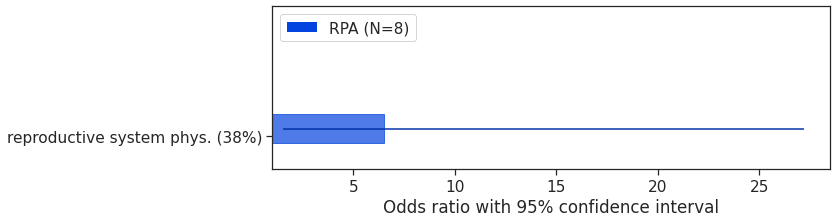

In [319]:
a = plot_hbar_comparison(results[results.observed>=2], communities=["C909"], mps="MP:0005389", color_idx=1, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["RPA"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005389 reproductive system phenotype


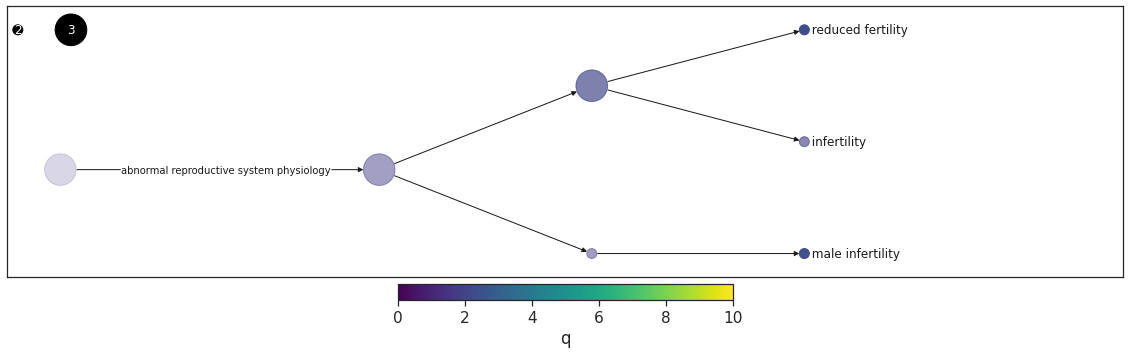

In [299]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C909", "MP:0005389", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=6, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

### Homestasis/Metabolism

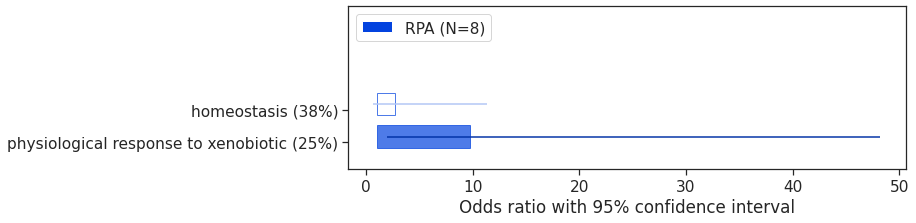

In [320]:
a = plot_hbar_comparison(results[results.observed>=2], communities=["C909"], mps="MP:0005376", color_idx=1, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["RPA"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005376 homeostasis/metabolism phenotype


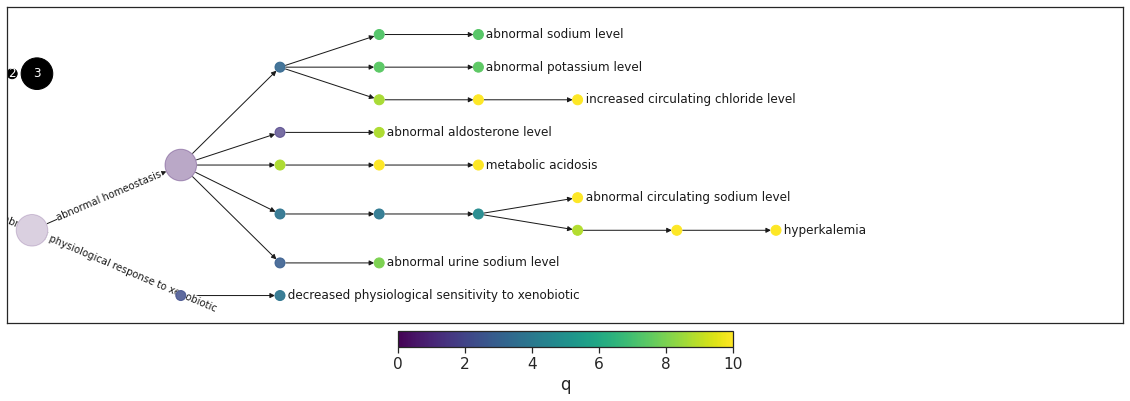

In [301]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C909", "MP:0005376", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

### Growth/body size

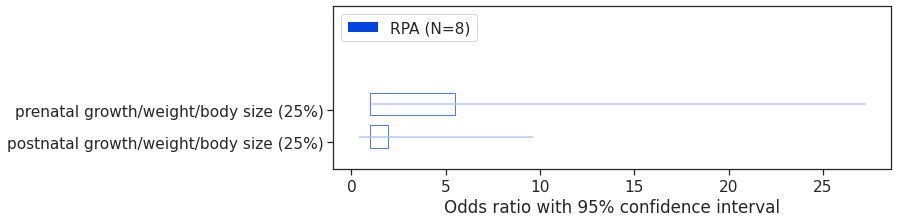

In [321]:
a = plot_hbar_comparison(results[results.observed>=2], communities=["C909"], mps="MP:0005378", color_idx=1, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["RPA"], sort_by="observed", label_number="percent_community")

PARENT: MP:0005378 growth/size/body region phenotype


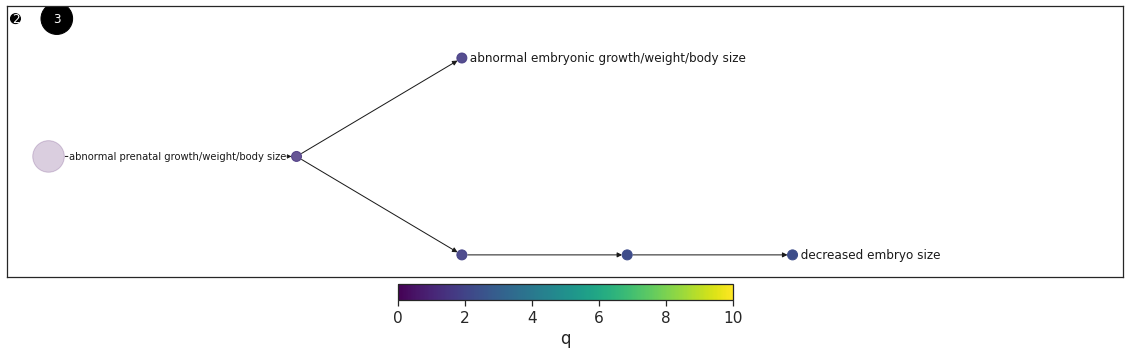

In [303]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C909", "MP:0005378", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=6, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)